<a href="https://colab.research.google.com/github/cejikeme/myworkrfc/blob/master/DDOS_on_TST__Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Chibuike Ejikeme



## 1.0 Purpose 😇

The purpose of this notebook is to experiment with the CICDDOS dataset 2019 and 2023 series classification model using the great **TST** model  library in 5 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model
5. Inference (predictions) on additional data

In general, there are 3 main ways to classify time series, based on the input to the neural network:

- raw data

- image data (encoded from raw data)

- feature data (extracted from raw data)

In this notebook, we will use the first approach.

### 1.1 Import libraries 📚

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [ ]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

os              : Linux-6.1.85+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.9
fastai          : 2.7.16
fastcore        : 1.5.55
torch           : 2.2.2+cu121
device          : 1 gpu (['Tesla T4'])
cpu cores       : 4
threads per cpu : 2
RAM             : 50.99 GB
GPU memory      : [15.0] GB


In [ ]:
!pip install kaggle
#from google.colab import drive
#drive.mount('/content/drive')



# 2.0 2019 Data 🔢

In this notebook, The first step is to import the datasets that woould be used
CICDDOS2019
CICDDOS2023

Add the datasets from kaggle to google collab

Download the dataset


### 2.1 Import datasets 💿


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s [cicddos2019]


mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kristianfrossos/cicddos2019                                       CiCDDoS2019                                           3GB  2024-03-24 05:52:45            131          2  0.75             
rodrigorosasilva/cic-ddos2019-30gb-full-dataset-csv-files         CIC-DDoS2019 30GB (Full Dataset CSV Files)            3GB  2023-11-04 04:08:10           1335         23  0.7058824        
pedrohauy/sampledtftpattackcicddos2019                            sampled-tftp-attack-cicddos2019                      13MB  2021-09-29 02:10:41            277          2  0.470588

In [ ]:
!kaggle datasets download -d rodrigorosasilva/cic-ddos2019-30gb-full-dataset-csv-files

Dataset URL: https://www.kaggle.com/datasets/rodrigorosasilva/cic-ddos2019-30gb-full-dataset-csv-files
License(s): other
100% 3.10G/3.10G [03:16<00:00, 17.3MB/s]
100% 3.10G/3.10G [03:16<00:00, 16.9MB/s]


In [ ]:
!unzip cic-ddos2019-30gb-full-dataset-csv-files.zip

Archive:  cic-ddos2019-30gb-full-dataset-csv-files.zip
  inflating: 01-12/DrDoS_DNS.csv     
  inflating: 01-12/DrDoS_LDAP.csv    
  inflating: 01-12/DrDoS_MSSQL.csv   
  inflating: 01-12/DrDoS_NTP.csv     
  inflating: 01-12/DrDoS_NetBIOS.csv  
  inflating: 01-12/DrDoS_SNMP.csv    
  inflating: 01-12/DrDoS_SSDP.csv    
  inflating: 01-12/DrDoS_UDP.csv     
  inflating: 01-12/Syn.csv           
  inflating: 01-12/TFTP.csv          
  inflating: 01-12/UDPLag.csv        
  inflating: 03-11/LDAP.csv          
  inflating: 03-11/MSSQL.csv         
  inflating: 03-11/NetBIOS.csv       
  inflating: 03-11/Portmap.csv       
  inflating: 03-11/Syn.csv           
  inflating: 03-11/UDP.csv           
  inflating: 03-11/UDPLag.csv        


### 2.2 Pre-processing

In [ ]:
#Select Protocol  CSV
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler

# Function to convert timestamp to Unix timestamp
def to_unix_timestamp(date_string, format='%Y-%m-%d %H:%M:%S'):
    try:
        return int(time.mktime(time.strptime(date_string, format)))
    except ValueError:
        return None

# Function to read and preprocess each CSV file
def preprocess_csv(filepath, attack_label, unique_id_prefix, timestamp_format='%Y-%m-%d %H:%M:%S'):
    # Read the CSV file
    df = pd.read_csv(filepath)

    # Remove spaces in column names
    df.columns = df.columns.str.strip()


    # Convert 'Timestamp' to Unix timestamp if it exists
    if 'Timestamp' in df.columns:
        df['Timestamp'] = df['Timestamp'].apply(lambda x: to_unix_timestamp(x, timestamp_format))
    else:
        raise KeyError(f"Timestamp column not found in file {filepath}")

    # Filter rows for both "BENIGN" and the given attack label
    benign_df = df[df['Label'] == 'BENIGN']
    attack_df = df[df['Label'] == attack_label]

    # Ensure the same number of rows in each label
    num_rows_benign = len(benign_df)
    attack_df = attack_df.sample(n=num_rows_benign, random_state=42)

    combined = pd.concat([benign_df, attack_df])

    # Add a unique identifier column
    combined['unique_id'] = f'{unique_id_prefix}_{attack_label}'

    return combined


# List of protocols and their corresponding CSV file paths
protocols = {
    "DrDoS_NTP": "/content/01-12/DrDoS_NTP.csv",
    "DrDoS_DNS": "/content/01-12/DrDoS_DNS.csv",
    "DrDoS_MSSQL": "/content/01-12/DrDoS_MSSQL.csv",
    "DrDoS_LDAP": "/content/01-12/DrDoS_LDAP.csv",
    "DrDoS_NetBIOS": "/content/01-12/DrDoS_NetBIOS.csv",
    "DrDoS_SNMP": "/content/01-12/DrDoS_SNMP.csv",
    "DrDoS_SSDP": "/content/01-12/DrDoS_SSDP.csv",
    "DrDoS_UDP": "/content/01-12/DrDoS_UDP.csv"
}

# Combine all attack datasets with "BENIGN" samples
combined_dfs = [preprocess_csv(filepath, attack_label, unique_id_prefix='Dataset') for attack_label, filepath in protocols.items()]
combined_df = pd.concat(combined_dfs).reset_index(drop=True)

# Sort by Unix timestamp
combined_df = combined_df.sort_values(by='Timestamp')

# Verify that all expected attack labels are present
expected_labels = {
    "DrDoS_NTP", "DrDoS_DNS", "DrDoS_MSSQL", "DrDoS_LDAP",
    "DrDoS_NetBIOS", "DrDoS_SNMP", "DrDoS_SSDP", "DrDoS_UDP"
}

present_labels = set(combined_df['Label'].unique())
missing_labels = expected_labels - present_labels

if missing_labels:
    print(f"Missing Attack Labels: {missing_labels}")
else:
    print("All expected attack labels are present.")

# Temporarily remove the 'Label' column
label = combined_df['Label']
combined_df.drop('Label', axis=1, inplace=True)

# Fill missing and infinite values
combined_df = combined_df.replace([float('inf'), float('-inf'), None], 0)
combined_df = combined_df.fillna(0)

combined_df['Label'] = label.values
temp_df = combined_df


All expected attack labels are present.


### 2.2a Feature engineering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

def create_sliding_window(data, window_size, step_size):
    return np.array([data[i:i+window_size] for i in range(0, len(data) - window_size + 1, step_size)])

def select_features(df, target_column, window_sizes, step_sizes):
    # Separate the features and the target variable
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values

    best_score = -np.inf
    best_window_size = None
    best_step_size = None
    best_model = None
    best_selected_features = None
    best_importances = None
    best_threshold = None

    # Iterate over possible window sizes and step sizes
    for window_size in window_sizes:
        for step_size in step_sizes:
            if window_size > len(X) or step_size > window_size:
                continue  # Skip invalid configurations

            # Create sliding windows
            X_windows = create_sliding_window(X, window_size, step_size)
            y_windows = create_sliding_window(y, window_size, step_size)[:, -1]  # Use the last value in the window as the target

            # Flatten the windows for model training
            X_windows_flat = X_windows.reshape((X_windows.shape[0], -1))

            # Define the model
            model = RandomForestClassifier(n_estimators=100, random_state=42)

            # Cross-validation
            tscv = TimeSeriesSplit(n_splits=5)
            scores = cross_val_score(model, X_windows_flat, y_windows, cv=tscv)
            avg_score = scores.mean()

            # Check if this configuration is the best so far
            if avg_score > best_score:
                best_score = avg_score
                best_window_size = window_size
                best_step_size = step_size

                # Fit the model with the best configuration
                best_model = model.fit(X_windows_flat, y_windows)

             # Feature selection
                importances = best_model.feature_importances_

                # Average the importances across windows for each original feature
                n_features = X.shape[1]
                importances = importances.reshape((window_size, n_features))
                averaged_importances = np.mean(importances, axis=0)

                best_importances = averaged_importances
                best_threshold = np.mean(best_importances)

                # Print the features and their importances before selection
                feature_names = df.drop(columns=[target_column]).columns
                feature_importances = pd.Series(best_importances, index=feature_names)
                print("Features and their importances before selection:")
                for feature, importance in feature_importances.items():
                    print(f"{feature}: {importance}")

                selector = SelectFromModel(best_model, threshold=best_threshold, prefit=True)
                best_selected_features = selector.get_support(indices=True)


    # Output selected features
    selected_feature_names = df.drop(columns=[target_column]).columns[best_selected_features % X.shape[1]]  # Modulo to get original feature names
    all_features = set(df.drop(columns=[target_column]).columns)
    selected_features_set = set(selected_feature_names)
    columns_to_drop = list(all_features - selected_features_set)

    print(f"Best window size: {best_window_size}")
    print(f"Best step size: {best_step_size}")
    print(f"Best cross-validation score: {best_score}")
    print(f"Variance threshold for feature selection: {best_threshold}")
    print(f"Feature importances: {best_importances}")
    print(f"Selected features: {selected_feature_names}")
    print(f"Columns to drop: {columns_to_drop}")

    # Create sliding windows with the best configuration
    X_windows_best = create_sliding_window(X, best_window_size, best_step_size)
    y_windows_best = create_sliding_window(y, best_window_size, best_step_size)[:, -1]

    return X_windows_best, y_windows_best, selected_feature_names, columns_to_drop


# Define possible window sizes and step sizes
window_sizes = [5, 10, 20]
step_sizes = [1, 2, 5]

# Assuming `combined_df` is already defined and contains the necessary data
df = combined_df.drop(columns=["Source IP", "Destination IP", "SimillarHTTP", "Flow ID","unique_id"])
df['Label'], uniques = pd.factorize(df['Label'])
target_column = 'Label'

# Call the function
X_windows_best, y_windows_best, selected_feature_names, columns_to_drop = select_features(df, 'Label', window_sizes, step_sizes)

# Output the results
print(f"X_windows_best shape: {X_windows_best.shape}")
print(f"y_windows_best shape: {y_windows_best.shape}")


Features and their importances before selection:
Unnamed: 0: 0.010841637462507861
Source Port: 0.007457610040901011
Destination Port: 0.002047360113474787
Protocol: 0.0001233407535789665
Timestamp: 0.0
Flow Duration: 0.0015095733457500238
Total Fwd Packets: 0.00534384811055118
Total Backward Packets: 0.00015354951097326763
Total Length of Fwd Packets: 0.007651445400057627
Total Length of Bwd Packets: 3.5093185678775006e-05
Fwd Packet Length Max: 0.006740012182757872
Fwd Packet Length Min: 0.03121126951745674
Fwd Packet Length Mean: 0.01839220497848271
Fwd Packet Length Std: 0.00015150701138810446
Bwd Packet Length Max: 3.041210206543551e-05
Bwd Packet Length Min: 2.569039223327535e-06
Bwd Packet Length Mean: 1.3689340109781264e-05
Bwd Packet Length Std: 4.638946319516269e-05
Flow Bytes/s: 0.005014851420443226
Flow Packets/s: 0.0009560800265228615
Flow IAT Mean: 0.0010020609369042351
Flow IAT Std: 0.0019952923400145127
Flow IAT Max: 0.0010402721159469368
Flow IAT Min: 0.0010094473232135

In [ ]:
combined_df = temp_df

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler



# List of columns to drop
# columns_to_drop = [
#      "Source IP", "Destination IP", "SimillarHTTP", "Flow ID",
#      "ECE Flag Count", "Unnamed: 0",
#      'Source Port', 'Destination Port', 'Protocol', 'Fwd PSH Flags',
#      'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
#      'Bwd Header Length', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
#      'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
#      'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
#      'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
#      'Source_Subnet', 'Destination_Subnet', 'Inbound']

#The list below is from feature engineering
# columns_to_drop = ['Fwd Packets/s',"Source IP", "Destination IP", "SimillarHTTP", "Flow ID",
#                   "ECE Flag Count", "Unnamed: 0" 'Flow ID', 'Fwd IAT Min', 'Active Max', 'Bwd IAT Total',
#                    'Fwd PSH Flags', 'Bwd Packet Length Min', 'CWE Flag Count', 'Bwd URG Flags', 'Idle Std', 'Down/Up Ratio', 'SYN Flag Count',
#                    'Bwd Packet Length Mean', 'Fwd Header Length', 'Fwd IAT Max', 'Bwd IAT Std', 'Idle Max', 'Total Backward Packets', 'Flow Packets/s',
#                   'min_seg_size_forward', 'Bwd PSH Flags', 'Bwd Packet Length Std', 'Bwd Avg Bytes/Bulk', 'Subflow Bwd Bytes', 'Bwd Header Length',
#                    'Avg Bwd Segment Size', 'Fwd IAT Mean', 'PSH Flag Count', 'Bwd Packet Length Max', 'Flow IAT Min', 'Fwd Header Length.1', 'Flow IAT Max', 'Active Min', 'ACK Flag Count']

# Drop only the columns that are present in the DataFrame
columns_to_drop_actual = [col for col in columns_to_drop if col in combined_df.columns]
combined_df = combined_df.drop(columns=columns_to_drop_actual)

# Standardize to zero mean and unit variance
columns_to_standardize = combined_df.drop(columns=['unique_id', 'Label']).columns
scaler = StandardScaler()
standardized_data = scaler.fit_transform(combined_df[columns_to_standardize])

# Create a DataFrame for the standardized data
standardized_df = pd.DataFrame(standardized_data, columns=columns_to_standardize)

# Re-add the 'unique_id' and 'Label' columns, placing them at the end
standardized_df['unique_id'] = combined_df['unique_id'].values
standardized_df['Label'] = combined_df['Label'].values

# Display the standardized DataFrame
df = standardized_df
print("Columns in DataFrame before dropping:")
print(df.columns)


Columns in DataFrame before dropping:
Index(['Unnamed: 0', 'Source Port', 'Destination Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Flow Bytes/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Std',
       'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd URG Flags',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'URG Flag Count',
       'Average Packet Size', 'Avg Fwd Segment Size', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Packets', 'Init_Win_bytes_forward',
       'Ini



### 2.3 Prepare Sliding Window

In [ ]:
from tsai.data.preparation import SlidingWindowPanel
X, y = SlidingWindowPanel(window_len=10, unique_id_cols=['unique_id'], stride=1, start=0, get_x=df.columns[:-2], get_y=['Label'],
                          horizon=0, seq_first=True, sort_by=None, ascending=True, return_key=False)(df)
X.shape, y.shape

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


((54966, 49, 10), (54966,))

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables
3. Length (aka time or sequence steps)

Variables = 1 for univariate datasets and >1 for multivariate.

**In this case, Format data in 3-d array**

In [ ]:
#Test cell ***********
import numpy as np
import pandas as pd
import os
ds_name = 'Heartbeat'
x_tsai, y_tsai, splits_tsai = get_UCR_data(ds_name, split_data=False)


It has not been possible to download the required files


## 2.4 Setup model

stratify set to False as the least populated class in o has only 1 member, which is too few.


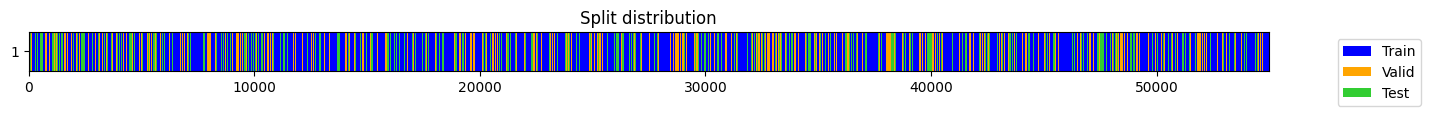

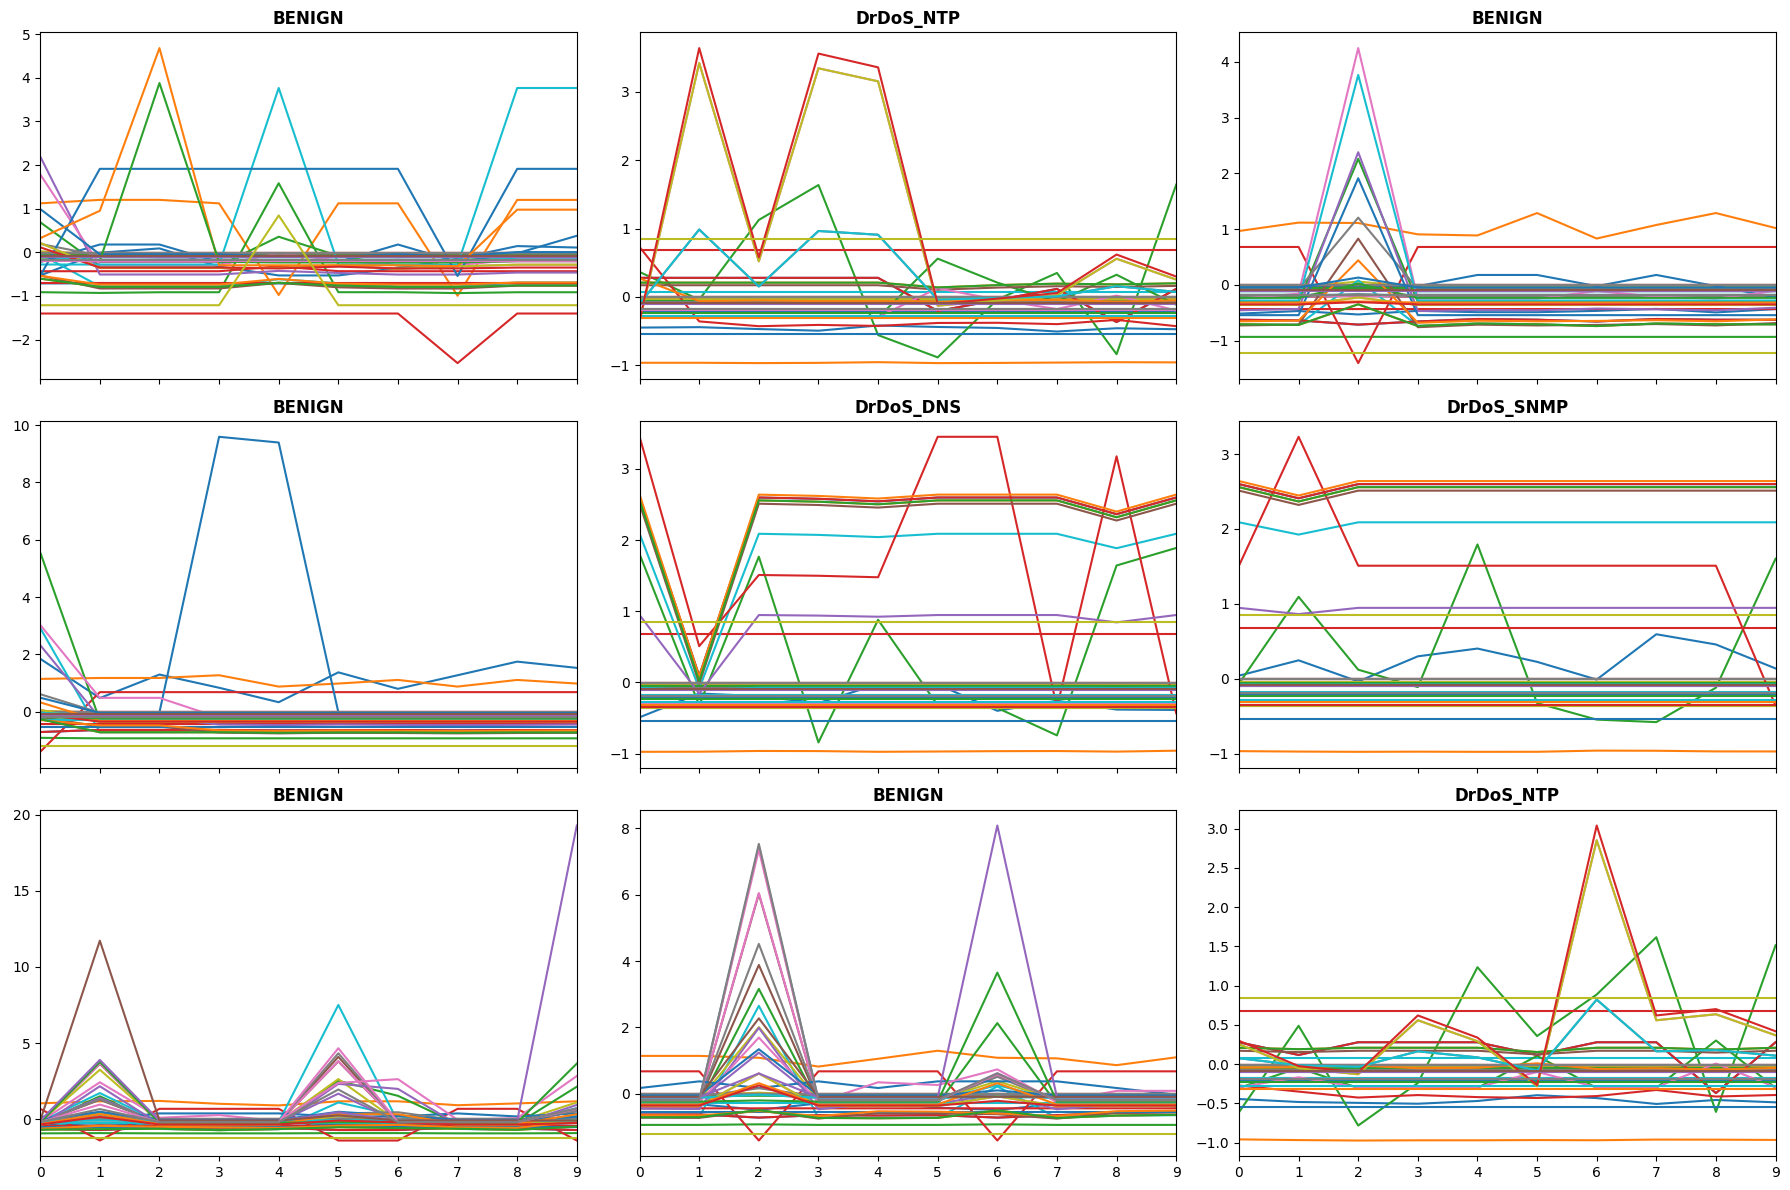

In [ ]:
#Create dataloaders
import torch
from tsai.all import TST, TSDatasets, TSDataLoaders, TSStandardize  # Use tsai.all to import TSDatasets, TSDataLoaders, and TSStandardize
from fastai.learner import Learner
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy
from torch.utils.data import TensorDataset, DataLoader
from fastai.data.transforms import Categorize
from tsai.all import get_splits, TSDatasets, TSDataLoaders, TSStandardize
from sklearn.model_selection import train_test_split
import os


# Assuming X and y are already defined, and y contains labels in the form of 0s and 1s
# Manually split off a test set before using `get_splits`
# X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_splits                = 1
valid_size              = 0.2
test_size               = 0.2
train_only              = False  # set to True for debugging (valid = train)
train_size              = None
stratify                = True
balance                 = False
shuffle                 = True
predefined_splits       = None
show_plot               = True
check_splits = True
random_state = 23

# Now use `get_splits` on the remaining data to create training and validation sets
splits = get_splits(X, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)


# Define parameters based on your data shape (24339, 85, 100)
bs = 64  # Batch size
c_in = 49  # Number of features per timestep (channels in)
c_out = 10  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
#max_seq_len = 405  # Maximum sequence length the model can handle

# Model configuration
d_model = c_in  # Feature dimensionality matches c_in
n_heads = 4  # Number of attention heads
d_k = d_v = d_model // n_heads  # Dimensionality of key/value vectors
d_ff = 256  # Dimensionality of the feedforward network
dropout = 0.1  # Dropout rate
activation = "gelu"  # Activation function
n_layers = 3  # Number of encoder layers
fc_dropout = 0.1  # Dropout rate in the fully connected layer

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs,bs*2], batch_tfms=[TSStandardize()], num_workers=0)

dls.show_batch()

# Define the TST model
tst_model = TST(c_in, c_out, seq_len=seq_len, d_model=d_model, n_heads=n_heads,
               d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, act=activation, n_layers=n_layers,
                fc_dropout=fc_dropout)



## 2.5 Build learner 🏗

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 839.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=00ad0b5a315b6717f859adf7d5e02460e64a1ed9462abbd8405d7f5e74bf3f79
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=41bdb829a749b2d257e754fdeb3b9dad79d0b401659aeb18ce809f4e1e831840
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


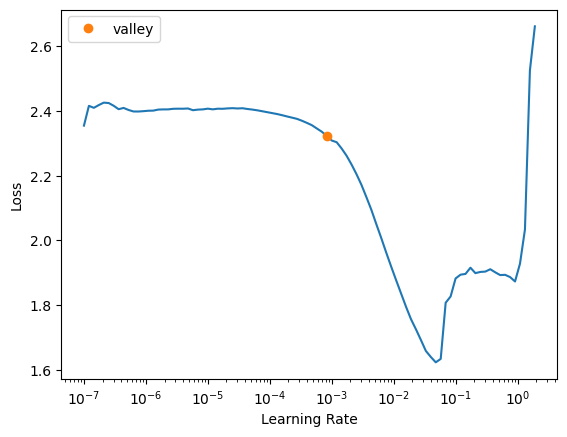

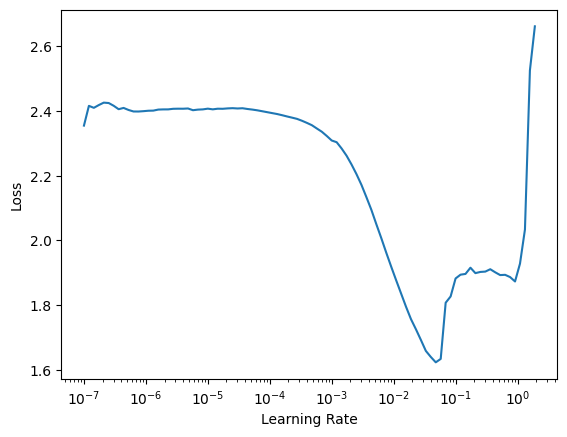

In [ ]:
!pip install fvcore
import torch
from fastai.vision.all import *
from tsai.all import *
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Assuming `dls` is your DataLoader and `tst_model` is your model
# Create the learner with the TST model and the data loaders
learner = Learner(dls, tst_model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])

# # Calculate and print FLOPs
# def print_flops(learner, dls):
#     # Generate a dummy input tensor based on the data loader's shape
#     dummy_input = next(iter(dls.train))[0][:1]

#     # Move the dummy input to the same device as the model
#     device = next(learner.model.parameters()).device
#     dummy_input = dummy_input.to(device)

#     # Calculate FLOPs
#     flops = FlopCountAnalysis(learner.model, dummy_input)

#     # Print the FLOPs and parameter count
#     print(f"FLOPs: {flops.total()}")
#     print(parameter_count_table(learner.model))

# # Call the print_flops function
# print_flops(learner, dls)

# Find an optimal learning rate
learner.lr_find() # Adjust `num_it` based on your dataset size

# Plot the learning rate finder results
learner.recorder.plot_lr_find()


In [ ]:
columns_to_dropA = ['Total Backward Packets', 'Fwd Packet Length Std', 'Idle Std', 'Fwd Avg Bulk Rate',
                   'SYN Flag Count', 'Bwd Avg Bulk Rate', 'Bwd Packets/s', 'CWE Flag Count', 'FIN Flag Count',
                   'Active Std', 'Flow IAT Min', 'Subflow Bwd Bytes', 'Fwd IAT Mean', 'Init_Win_bytes_forward',
                   'Flow Packets/s', 'Fwd Avg Bytes/Bulk', 'PSH Flag Count', 'Packet Length Variance',
                   'Fwd Header Length.1', 'Fwd Header Length', 'Fwd IAT Min', 'Bwd URG Flags', 'Active Max',
                   'Protocol', 'RST Flag Count', 'Flow IAT Max', 'Idle Min', 'Fwd URG Flags', 'Bwd IAT Mean',
                   'Packet Length Std', 'ECE Flag Count', 'Total Length of Bwd Packets', 'Timestamp', 'Fwd PSH Flags',
                   'Active Min', 'Bwd Avg Bytes/Bulk', 'Bwd Packet Length Mean', 'Active Mean', 'Bwd IAT Std',
                   'URG Flag Count', 'Bwd PSH Flags', 'ACK Flag Count', 'Bwd Packet Length Max', 'Fwd Packets/s',
                   'Down/Up Ratio', 'Bwd Header Length', 'Avg Bwd Segment Size', 'Bwd Avg Packets/Bulk',
                   'Fwd Avg Packets/Bulk', 'min_seg_size_forward', 'Bwd IAT Total', 'Bwd Packet Length Std',
                   'Fwd IAT Max', 'Idle Max', 'Init_Win_bytes_backward', 'Bwd Packet Length Min', 'Idle Mean']

columns_to_dropB = [
    "Source IP", "Destination IP", "SimillarHTTP", "Flow ID",
    "ECE Flag Count", "Unnamed: 0",
    'Source Port', 'Destination Port', 'Protocol', 'Fwd PSH Flags',
    'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
    'Bwd Header Length', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
    'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate',
    'Source_Subnet', 'Destination_Subnet', 'Inbound'
]

# Convert lists to sets for easier comparison
setA = set(columns_to_dropA)
setB = set(columns_to_dropB)

# Find similarities
similarities = setA.intersection(setB)

# Find differences
unique_to_A = setA - setB
unique_to_B = setB - setA

print("Similarities:")
print(similarities)

print("\nUnique to columns_to_dropA:")
print(unique_to_A)

print("\nUnique to columns_to_dropB:")
print(unique_to_B)


Similarities:
{'Bwd Avg Packets/Bulk', 'RST Flag Count', 'Fwd Avg Packets/Bulk', 'CWE Flag Count', 'ACK Flag Count', 'Bwd Avg Bytes/Bulk', 'Fwd PSH Flags', 'ECE Flag Count', 'PSH Flag Count', 'FIN Flag Count', 'SYN Flag Count', 'Fwd Avg Bytes/Bulk', 'Protocol', 'Bwd Header Length', 'Bwd PSH Flags', 'URG Flag Count', 'Bwd URG Flags', 'Bwd Avg Bulk Rate', 'Fwd Header Length', 'Fwd Avg Bulk Rate', 'Fwd URG Flags'}

Unique to columns_to_dropA:
{'Fwd Header Length.1', 'Idle Std', 'Down/Up Ratio', 'Bwd Packet Length Mean', 'Subflow Bwd Bytes', 'Avg Bwd Segment Size', 'Bwd IAT Total', 'Bwd IAT Mean', 'Flow IAT Max', 'Active Min', 'Total Backward Packets', 'Packet Length Variance', 'Bwd Packet Length Min', 'Flow Packets/s', 'Timestamp', 'Bwd IAT Std', 'Total Length of Bwd Packets', 'Packet Length Std', 'Bwd Packet Length Max', 'Idle Mean', 'Fwd IAT Min', 'Init_Win_bytes_backward', 'Bwd Packets/s', 'Flow IAT Min', 'Idle Max', 'Fwd Packet Length Std', 'Fwd IAT Mean', 'Fwd Packets/s', 'Active Std

### Train model 🚵🏼‍

In [ ]:
learner = Learner(dls, tst_model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learner.fit_one_cycle(1, lr_max=1e-3 )


epoch,train_loss,valid_loss,accuracy,time
0,0.101331,0.103138,0.961703,00:23


epoch,train_loss,valid_loss,fbeta_score,time
0,0.127691,0.090340,0.782053,00:10
1,0.091213,0.095389,0.819523,00:10
2,0.073049,0.086397,0.833049,00:10
3,0.073876,0.068639,0.859203,00:10
4,0.076969,0.070582,0.856030,00:09


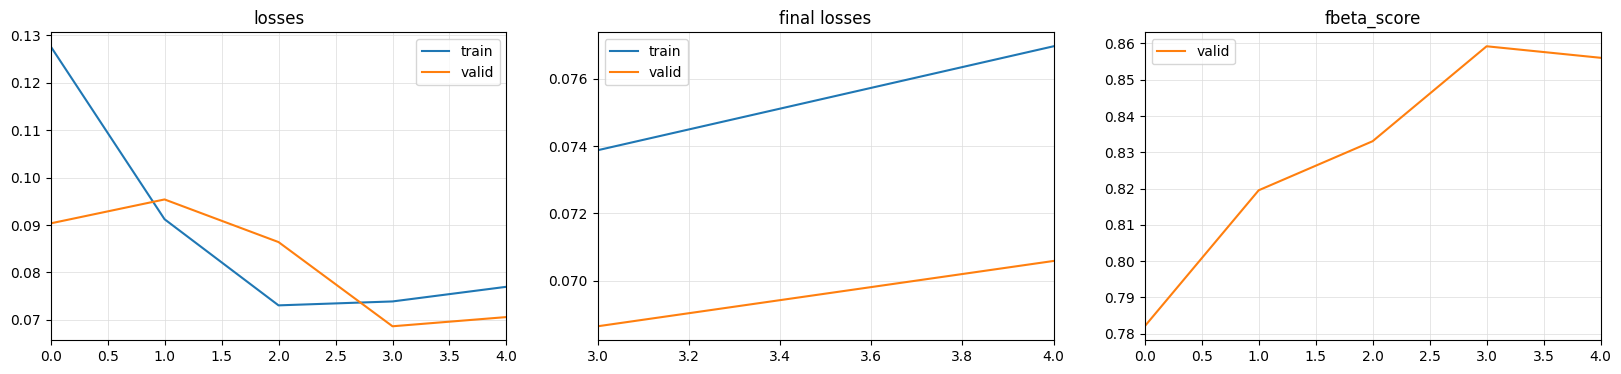

In [ ]:
from fastai.learner import Learner

learner.fit_one_cycle(5, lr_max=1e-3 )

#plot the result
learner.recorder.plot_metrics()

### Visualize results 👁

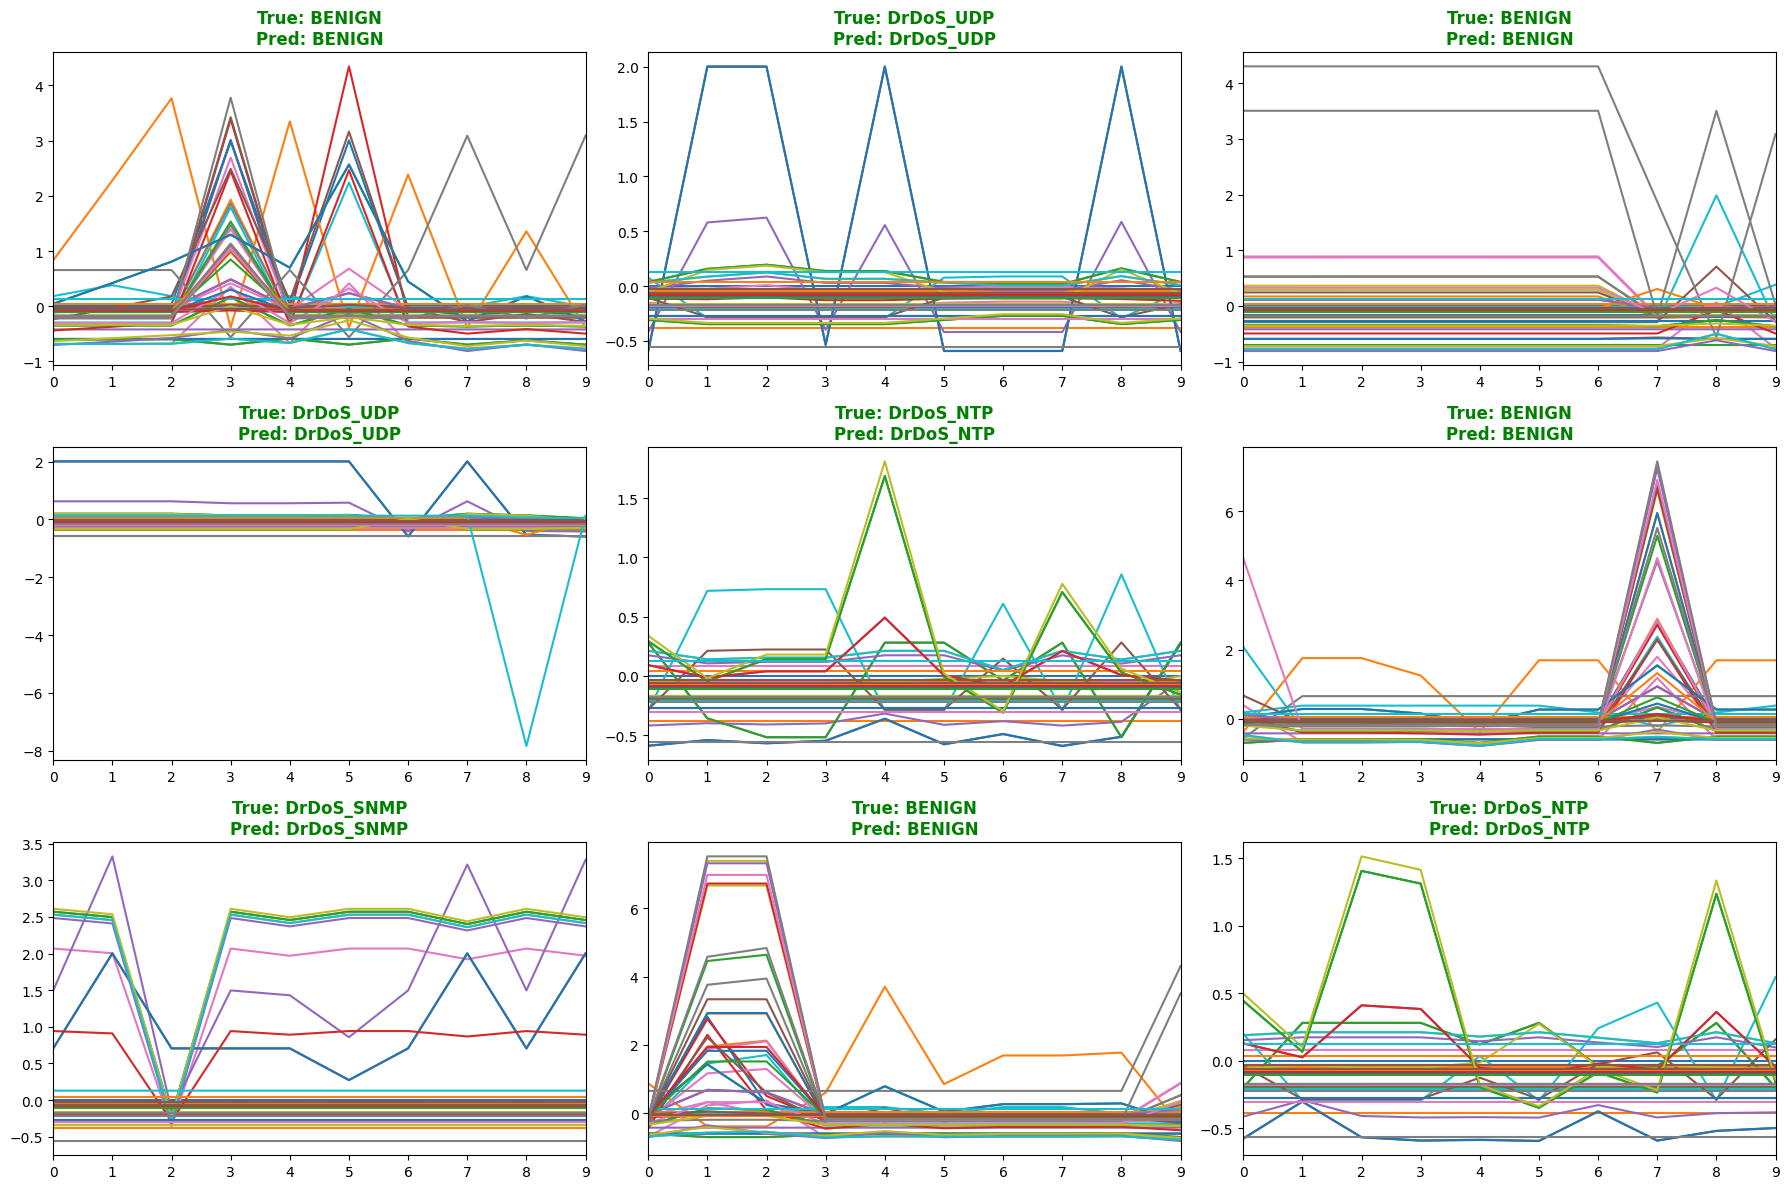

In [ ]:
learner.show_results()

## 2.6 Validations and Evaluation

In [ ]:
# Assuming valid_dl is your validation DataLoader
# Prepare the test dataset and DataLoader

X_test, y_test = X[splits[1]], y[splits[1]]

test_ds = dls.valid.dataset.add_test(X_test, y_test)  # Replace X_test, y_test with your actual test data
test_dl = dls.valid.new(test_ds)

# Get a batch from the test DataLoader
batch = next(iter(test_dl))

# Make predictions on the test batch
preds, _, decoded_preds = learner.get_preds(dl=test_dl, with_decoded=True)

# decoded_preds are the predicted classes


## 2.7 View Evaluation Results and plots  🎉

Print sample predictions

In [ ]:
# Print first 5 predicted probabilities
print("First 5 Predicted Probabilities:\n", preds[:5])
# Print first 5 predicted classes
print("\nFirst 5 Predicted Classes:\n", decoded_preds[:5])

First 5 Predicted Probabilities:
 tensor([[6.2801e-07, 6.5654e-07, 7.6226e-08, 7.2549e-09, 1.0000e+00, 3.1039e-09,
         3.3857e-06, 1.8740e-09, 1.2980e-09, 5.7124e-08],
        [1.2272e-05, 1.0984e-05, 1.8415e-06, 5.6040e-04, 1.7370e-04, 3.5340e-05,
         1.3525e-06, 2.2989e-01, 7.6932e-01, 3.1526e-07],
        [9.9999e-01, 1.9740e-06, 1.5853e-07, 2.1564e-06, 1.1938e-07, 1.5613e-09,
         3.3564e-06, 1.1676e-07, 5.5673e-08, 3.2429e-09],
        [9.9998e-01, 8.6269e-06, 3.5194e-07, 8.0215e-06, 3.3679e-07, 4.2830e-10,
         3.7045e-06, 9.4707e-07, 2.3561e-07, 6.3988e-09],
        [1.4127e-07, 2.3804e-07, 2.6186e-08, 6.7704e-10, 1.0000e+00, 7.2490e-10,
         4.6409e-07, 4.5237e-08, 1.8937e-08, 1.6400e-08]])

First 5 Predicted Classes:
 tensor([4, 8, 0, 0, 4])


Calculate and Print Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

y_true = []
for batch in test_dl:
    y_true.extend(batch[1].cpu().numpy())  # Assuming batch[1] contains labels; adjust if your DataLoader is structured differently
y_true = np.array(y_true)

# Ensure decoded_preds is a NumPy array for comparison
decoded_preds_np = decoded_preds.numpy() if not isinstance(decoded_preds, np.ndarray) else decoded_preds

# Calculate accuracy
accuracy = accuracy_score(y_true, decoded_preds_np)
print("\nAccuracy on Test Set:", accuracy)



Accuracy on Test Set: 0.971163467661239


Show probabilty Matrix


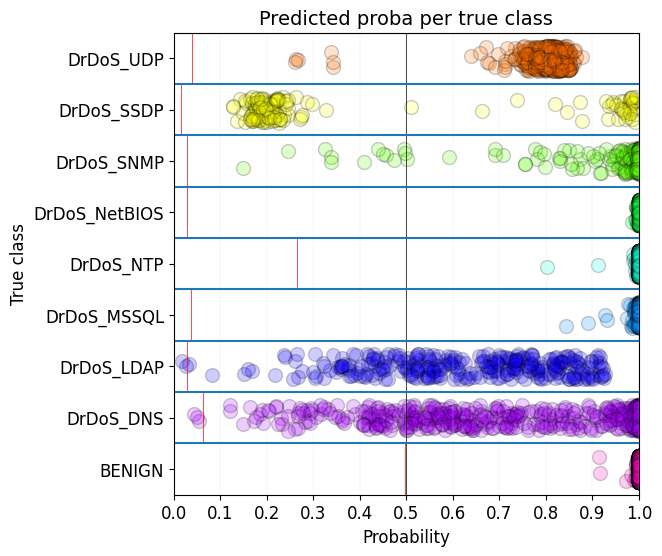

In [ ]:
# Plot predicted probabilities for a subset of the validation or test set
learner.show_probas()


Plot Confusion Matrix:


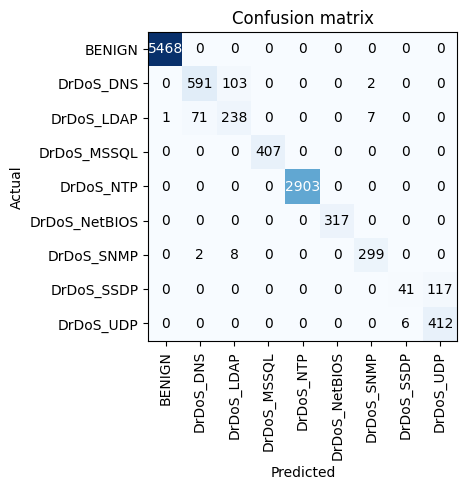

In [ ]:
interp = ClassificationInterpretation.from_learner(learner, dl=test_dl)  # Specify the DataLoader if evaluating on test data
interp.plot_confusion_matrix()


## 2.8 RNN ✈

In [ ]:
# Make sure tsai and its dependencies are installed
# pip install tsai

from tsai.all import *  # This imports the necessary modules from tsai

# Check and ensure that 'dls' is defined and correctly configured
dls2 = dls

# Parameters
bs = 64  # Batch size
c_in = 58  # Number of features per timestep (channels in)
c_out = 10  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
fc_dropout = 0.5
rnn_dropout = 0.5

# Define the RNN model
# Assuming RNN is correctly imported and available from tsai
model2 = RNN(c_in=c_in, c_out=c_out, hidden_size=100, n_layers=3, bias=True,
             rnn_dropout=rnn_dropout, bidirectional=False, fc_dropout=fc_dropout, init_weights=True)

# Learner initialization
learn = Learner(dls2, model2, metrics=accuracy)

# Model training
learn.fit_one_cycle(1, 3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.165545,0.154590,0.927772,00:04


In [ ]:
learn = Learner(dls2, model2, metrics=[FBeta(beta=1, average='macro')])
print_flops(learn, dls2)

# Model training
learn.fit_one_cycle(1, 3e-3)

FLOPs: 1000
| name               | #elements or shape   |
|:-------------------|:---------------------|
| model              | 57.4K                |
|  rnn               |  56.4K               |
|   rnn.weight_ih_l0 |   (100, 58)          |
|   rnn.weight_hh_l0 |   (100, 100)         |
|   rnn.bias_ih_l0   |   (100,)             |
|   rnn.bias_hh_l0   |   (100,)             |
|   rnn.weight_ih_l1 |   (100, 100)         |
|   rnn.weight_hh_l1 |   (100, 100)         |
|   rnn.bias_ih_l1   |   (100,)             |
|   rnn.bias_hh_l1   |   (100,)             |
|   rnn.weight_ih_l2 |   (100, 100)         |
|   rnn.weight_hh_l2 |   (100, 100)         |
|   rnn.bias_ih_l2   |   (100,)             |
|   rnn.bias_hh_l2   |   (100,)             |
|  fc                |  1.0K                |
|   fc.weight        |   (10, 100)          |
|   fc.bias          |   (10,)              |


epoch,train_loss,valid_loss,fbeta_score,time
0,0.158888,0.155719,0.612943,00:04


###  2.8b TransformerRNN

In [ ]:

# Parameters
bs = 64  # Batch size
c_in = 58  # Number of features per timestep (channels in)
c_out = 10  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
fc_dropout = 0.5
rnn_dropout = 0.5

# Define the RNN model
# Assuming RNN is correctly imported and available from tsai
model3 = TransformerLSTMPlus(c_in=c_in, c_out=c_out, seq_len = seq_len, num_encoder_layers=3, bias=True, bidirectional=False)

# Learner initialization
learn = Learner(dls2, model3, metrics=accuracy)
print_flops(learn, dls2)

# Model training
learn.fit_one_cycle(1, 3e-3)

backbone.enc_layers.0.self_attn.out_proj, backbone.enc_layers.1.self_attn.out_proj, backbone.enc_layers.2.self_attn.out_proj


FLOPs: 17808640
| name                           | #elements or shape   |
|:-------------------------------|:---------------------|
| model                          | 1.9M                 |
|  backbone                      |  1.9M                |
|   backbone.pos_encoding        |   (1, 10, 128)       |
|   backbone.proj_linear         |   7.6K               |
|    backbone.proj_linear.weight |    (128, 58)         |
|    backbone.proj_linear.bias   |    (128,)            |
|   backbone.enc_layers          |   1.8M               |
|    backbone.enc_layers.0       |    0.6M              |
|    backbone.enc_layers.1       |    0.6M              |
|    backbone.enc_layers.2       |    0.6M              |
|   backbone.rnn_layers          |   0.1M               |
|    backbone.rnn_layers.0       |    0.1M              |
|  head                          |  1.3K                |
|   head.2                       |   1.3K               |
|    head.2.weight               |    (10, 128)         

epoch,train_loss,valid_loss,accuracy,time
0,0.170385,0.162982,0.927590,00:10


In [ ]:
learn = Learner(dls2, model3, metrics=[FBeta(beta=1, average='macro')])

# Model training
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,fbeta_score,time
0,0.369386,0.349585,0.441506,00:11


### 2.8c LSTM

In [ ]:
# Make sure tsai and its dependencies are installed
# pip install tsai

from tsai.all import *  # This imports the necessary modules from tsai

# Check and ensure that 'dls' is defined and correctly configured
dls2 = dls

# Parameters
bs = 64  # Batch size
c_in = 58  # Number of features per timestep (channels in)
c_out = 10  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
fc_dropout = 0.5
rnn_dropout = 0.5

# Define the RNN model
# Assuming RNN is correctly imported and available from tsai
model4 = LSTM(c_in=c_in, c_out=c_out, hidden_size=100, n_layers=2, bias=True,
             rnn_dropout=rnn_dropout, bidirectional=False, fc_dropout=fc_dropout, init_weights=True)

# Learner initialization
learn = Learner(dls2, model2, metrics=accuracy)

# Model training
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.151558,0.134951,0.940781,00:04


In [ ]:
print_flops(learn, dls2)


FLOPs: 1000
| name               | #elements or shape   |
|:-------------------|:---------------------|
| model              | 57.4K                |
|  rnn               |  56.4K               |
|   rnn.weight_ih_l0 |   (100, 58)          |
|   rnn.weight_hh_l0 |   (100, 100)         |
|   rnn.bias_ih_l0   |   (100,)             |
|   rnn.bias_hh_l0   |   (100,)             |
|   rnn.weight_ih_l1 |   (100, 100)         |
|   rnn.weight_hh_l1 |   (100, 100)         |
|   rnn.bias_ih_l1   |   (100,)             |
|   rnn.bias_hh_l1   |   (100,)             |
|   rnn.weight_ih_l2 |   (100, 100)         |
|   rnn.weight_hh_l2 |   (100, 100)         |
|   rnn.bias_ih_l2   |   (100,)             |
|   rnn.bias_hh_l2   |   (100,)             |
|  fc                |  1.0K                |
|   fc.weight        |   (10, 100)          |
|   fc.bias          |   (10,)              |


## 2.9 Other models- XGB and LR ⚾

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder
import xgboost as xgb
import numpy as np

# Separate features and target
X = df.iloc[:, :-1]  # All rows, all columns except the last one as features
y = df.iloc[:, -1]   # All rows, last column as target

# Encode categorical features in X
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# Convert y to numeric if it is not already
y = pd.factorize(y)[0]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression for multiclass
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression F1 Score (Macro):", f1_score(y_test, lr_predictions, average='macro'))

# AUC-ROC (Multiclass requires binarization of the label)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
lr_probs = lr_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_bin, lr_probs, multi_class='ovr', average='macro')
print("Logistic Regression AUC-ROC (Macro):", roc_auc)

print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))

# XGBoost for multiclass
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Adjust XGBoost parameters for multiclass
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss'
}

# Train XGBoost model
epochs = 10
xgb_model = xgb.train(params, dtrain, epochs)
xgb_predictions = np.argmax(xgb_model.predict(dtest), axis=1)

# Metrics
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost F1 Score (Macro):", f1_score(y_test, xgb_predictions, average='macro'))

# AUC-ROC for XGBoost
xgb_probs = xgb_model.predict(dtest)
roc_auc_xgb = roc_auc_score(y_test_bin, xgb_probs, multi_class='ovr', average='macro')
print("XGBoost AUC-ROC (Macro):", roc_auc_xgb)

print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))


Logistic Regression Accuracy: 0.9922480620155039
Logistic Regression F1 Score (Macro): 0.9882942137292763
Logistic Regression AUC-ROC (Macro): 0.9995231601824225
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8223
           1       0.99      0.99      0.99      1058
           2       0.98      1.00      0.99       489
           3       1.00      0.99      0.99       605
           4       1.00      0.98      0.99      4341
           5       0.95      0.99      0.97       467
           6       0.99      0.97      0.98       427
           7       1.00      0.98      0.99       235
           8       1.00      1.00      1.00       667

    accuracy                           0.99     16512
   macro avg       0.99      0.99      0.99     16512
weighted avg       0.99      0.99      0.99     16512

XGBoost Accuracy: 0.9951550387596899
XGBoost F1 Score (Macro): 0.9965638834330801
XGBoost

# 3.0 2023 data 🔢

### 3.1 Import  2023 datasets 💿


In [ ]:
!kaggle datasets download -d akashdogra/cic-iot-2023

Dataset URL: https://www.kaggle.com/datasets/akashdogra/cic-iot-2023
License(s): unknown
100% 2.77G/2.77G [03:03<00:00, 18.8MB/s]
100% 2.77G/2.77G [03:03<00:00, 16.2MB/s]


In [ ]:
import os

# Directory where the files will be saved and unzipped into
save_directory = '2023-data'

# Ensure the directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Unzip the dataset into the specified directory
!unzip cic-iot-2023.zip -d {save_directory}



Archive:  cic-iot-2023.zip
  inflating: 2023-data/part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00010-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv  
  inflating: 2023-data/part-00011-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-

### 3.2 Pre-processing data


Stratified Sampling


Boosting Minor Class

In [7]:
import pandas as pd
import glob
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Path to the directory containing CSV files
path = '/content/2023-data'  # Adjust as necessary
file_pattern = f"{path}/part-*.csv"
file_list = sorted(glob.glob(file_pattern))

# Placeholder DataFrame
full_df = pd.DataFrame()

# Read each file
for file in file_list:
    temp_df = pd.read_csv(file)
    # Append to the full DataFrame
    full_df = pd.concat([full_df, temp_df], ignore_index=True)

print(full_df.columns)



Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')


In [ ]:
# Further Processing....

# Assuming the correct column name is 'label'
label_column_name = 'label'  # Adjust if necessary based on the actual column name

# Given label counts
label_counts = {
    'DDoS-ICMP_Flood': 7200504,
    'DDoS-UDP_Flood': 5412287,
    'DDoS-TCP_Flood': 4497667,
    'DDoS-PSHACK_Flood': 4094755,
    'DDoS-SYN_Flood': 4059190,
    'DDoS-RSTFINFlood': 4045285,
    'DDoS-ACK_Fragmentation': 285104,
    'DDoS-ICMP_Fragmentation': 452489,
    'DDoS-SynonymousIP_Flood': 3598138,
    'DDoS-UDP_Fragmentation': 286925,
    'DDoS-HTTP_Flood': 28790,
    'DDoS-SlowLoris': 23426,
    'BenignTraffic': 1098195
}

total_rows = sum(label_counts.values())
total_sample_size = 200000  # Total number of samples desired

# Calculate sample sizes based on proportions
sample_sizes = {label: int((count / total_rows) * total_sample_size) for label, count in label_counts.items()}

# Additional samples for minor classes to ensure adequate representation
minor_class_additional_samples = 50000  # For DDoS-HTTP_Flood and DDoS-SlowLoris

# Update minor class sample sizes
sample_sizes['DDoS-HTTP_Flood'] += minor_class_additional_samples
sample_sizes['DDoS-SlowLoris'] += minor_class_additional_samples
sample_sizes['BenignTraffic'] += minor_class_additional_samples
sample_sizes['DDoS-ACK_Fragmentation'] += minor_class_additional_samples
sample_sizes['DDoS-ICMP_Fragmentation'] += minor_class_additional_samples
sample_sizes['DDoS-UDP_Fragmentation'] += minor_class_additional_samples

# Perform the sampling
sampled_df = pd.DataFrame()
for label, size in sample_sizes.items():
    label_df = full_df[full_df[label_column_name] == label]  # Use the correct column name
    sampled_label_df = label_df.sample(n=min(size, len(label_df)), random_state=42, replace=True if size > len(label_df) else False)
    sampled_df = pd.concat([sampled_df, sampled_label_df], axis=0)

# Reset the index of the final sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

# Feature selection

# Assuming df is your DataFrame and 'Label' is the target variable
df = sampled_df  # Use the sampled DataFrame
target_column = df['label']



## Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

def create_sliding_window(data, window_size, step_size):
    return np.array([data[i:i+window_size] for i in range(0, len(data) - window_size + 1, step_size)])

def select_features(df, target_column, window_sizes, step_sizes):
    # Separate the features and the target variable
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    best_score = -np.inf
    best_window_size = None
    best_step_size = None
    best_importances = None
    best_model = None
    best_selected_features = None

    # Iterate over possible window sizes and step sizes
    for window_size in window_sizes:
        for step_size in step_sizes:
            if window_size > len(X) or step_size > window_size:
                continue  # Skip invalid configurations

            # Create sliding windows
            X_windows = create_sliding_window(X, window_size, step_size)
            y_windows = create_sliding_window(y, window_size, step_size)[:, -1]  # Use the last value in the window as the target

            # Flatten the windows for model training
            X_windows_flat = X_windows.reshape((X_windows.shape[0], -1))

            # Define the model
            model = RandomForestClassifier(n_estimators=100, random_state=42)

            # Cross-validation
            tscv = TimeSeriesSplit(n_splits=5)
            scores = cross_val_score(model, X_windows_flat, y_windows, cv=tscv)
            avg_score = scores.mean()

            # Check if this configuration is the best so far
            if avg_score > best_score:
                best_score = avg_score
                best_window_size = window_size
                best_step_size = step_size

                # Fit the model with the best configuration
                best_model = model.fit(X_windows_flat, y_windows)

             # Feature selection
                importances = best_model.feature_importances_

                # Average the importances across windows for each original feature
                n_features = X.shape[1]
                importances = importances.reshape((window_size, n_features))
                averaged_importances = np.mean(importances, axis=0)

                best_importances = averaged_importances
                best_threshold = np.mean(best_importances)

                # Print the features and their importances before selection
                feature_names = df.drop(columns=[target_column]).columns
                feature_importances = pd.Series(best_importances, index=feature_names)
                print("Features and their importances before selection:")
                for feature, importance in feature_importances.items():
                    print(f"{feature}: {importance}")

                selector = SelectFromModel(best_model, threshold=best_threshold, prefit=True)
                best_selected_features = selector.get_support(indices=True)

     # Output selected features
    selected_feature_names = df.drop(columns=[target_column]).columns[best_selected_features % X.shape[1]]  # Modulo to get original feature names
    all_features = set(df.drop(columns=[target_column]).columns)
    selected_features_set = set(selected_feature_names)
    columns_to_drop = list(all_features - selected_features_set)

    print(f"Best window size: {best_window_size}")
    print(f"Best step size: {best_step_size}")
    print(f"Best cross-validation score: {best_score}")
    print(f"Variance threshold for feature selection: {best_threshold}")
    print(f"Feature importances: {best_importances}")
    print(f"Selected features: {selected_feature_names}")
    print(f"Columns to drop: {columns_to_drop}")

    # Create sliding windows with the best configuration
    X_windows_best = create_sliding_window(X, best_window_size, best_step_size)
    y_windows_best = create_sliding_window(y, best_window_size, best_step_size)[:, -1]

    return X_windows_best, y_windows_best, selected_feature_names, columns_to_drop


# Define possible window sizes and step sizes
window_sizes = [5, 10, 20]
step_sizes = [1, 2, 5]

# Drop the non-numeric columns in your actual DataFrame

df['label'], uniques = pd.factorize(df['label'])
# Call the function
X_windows_best, y_windows_best, selected_feature_names, columns_to_drop = select_features(df, 'label', window_sizes, step_sizes)

# Output the results
print(f"X_windows_best shape: {X_windows_best.shape}")
print(f"y_windows_best shape: {y_windows_best.shape}")


KeyboardInterrupt: 

In [ ]:
# Separate features and target
X = df.drop(columns=[label_column_name])  # Exclude the target column
y = target_column

# Initialize VarianceThreshold
# The threshold parameter is the variance below which features will be removed
# For example, 0.01 means that features with variance less than 0.01 will be removed
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the data
X_selected = selector.fit_transform(X)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

# Create a new DataFrame with the selected features
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Add the target column back to the DataFrame
X_selected_df[label_column_name] = y.values

# Drop specified columns
columns_to_drop = ['Drate', 'fin_flag_number', 'syn_flag_number','rst_flag_number',
                   'psh_flag_number', 'ack_flag_number','ece_flag_number',
                   'cwr_flag_number','HTTP', 'HTTPS', 'DNS','Telnet','SMTP',
                   'SSH', 'IRC', 'TCP',  'UDP', 'DHCP', 'ARP', 'ICMP','IPv', 'LLC']
X_selected_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')



# Verify the shape of the new DataFrame
print(X_selected_df.shape)
print(X_selected_df.columns)
# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(X_selected_df.drop(columns=[label_column_name]))
standardized_df = pd.DataFrame(standardized_data, columns=X_selected_df.columns[:-1])
standardized_df[label_column_name] = target_column

(451913, 25)
Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
       'rst_count', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight',
       'label'],
      dtype='object')


In [ ]:
df = standardized_df
df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,ack_count,syn_count,fin_count,urg_count,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,-0.019266,-0.290600,-1.238426,-0.317196,-0.094003,-0.094003,-0.322079,-0.565101,-0.267377,-0.238407,...,-0.815169,-0.854912,-0.002425,0.003504,-0.973249,-0.814645,-0.311907,-1.200321,0.003408,DDoS-ICMP_Flood
1,-0.019266,-0.290600,-1.238426,-0.317196,-0.094125,-0.094125,-0.322079,-0.565101,-0.267377,-0.238407,...,-0.815169,-0.854912,-0.003021,0.003504,-0.973249,-0.814645,-0.311907,-1.200321,0.003408,DDoS-ICMP_Flood
2,-0.019266,-0.290600,-1.238426,-0.317196,-0.094129,-0.094129,-0.322079,-0.565101,-0.267377,-0.238407,...,-0.815169,-0.854912,-0.003178,0.003504,-0.973249,-0.814645,-0.311907,-1.200321,0.003408,DDoS-ICMP_Flood
3,-0.019266,-0.290600,-1.238426,-0.317196,-0.092718,-0.092718,-0.322079,-0.565101,-0.267377,-0.238407,...,-0.815169,-0.854912,-0.002459,0.003504,-0.973249,-0.814645,-0.311907,-1.200321,0.003408,DDoS-ICMP_Flood
4,-0.019266,-0.290600,-1.238426,-0.317196,-0.094090,-0.094090,-0.322079,-0.565101,-0.267377,-0.238407,...,-0.815169,-0.854912,-0.003036,0.003504,-0.973249,-0.814645,-0.311907,-1.200321,0.003408,DDoS-ICMP_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451908,0.030485,-0.287937,0.539682,0.775463,-0.094012,-0.094012,1.310083,0.474126,-0.267377,-0.230189,...,-0.409148,-0.598488,-2.821677,-2.817563,-0.424139,-0.408733,-0.281121,0.816206,-2.822459,BenignTraffic
451909,0.067456,6.012109,-0.239489,-0.317196,-0.093234,-0.093234,-0.322079,2.032968,-0.267377,1.473704,...,5.123292,6.509377,2.824378,2.824571,3.488812,5.105461,5.476967,1.040265,2.829275,BenignTraffic
451910,0.081473,0.518846,-0.139595,1.875956,-0.093737,-0.093737,-0.322079,0.214319,-0.267377,3.570699,...,3.677822,-0.624394,2.824331,2.824571,2.026702,3.680960,3.023578,1.040265,2.829275,BenignTraffic
451911,0.200096,8.126112,0.419809,4.864125,-0.093688,-0.093688,-0.322079,-0.565101,-0.267377,3.515911,...,-0.631483,-0.700575,-2.821677,-2.817563,-0.649971,-0.631008,-0.305624,0.816206,-2.822459,BenignTraffic


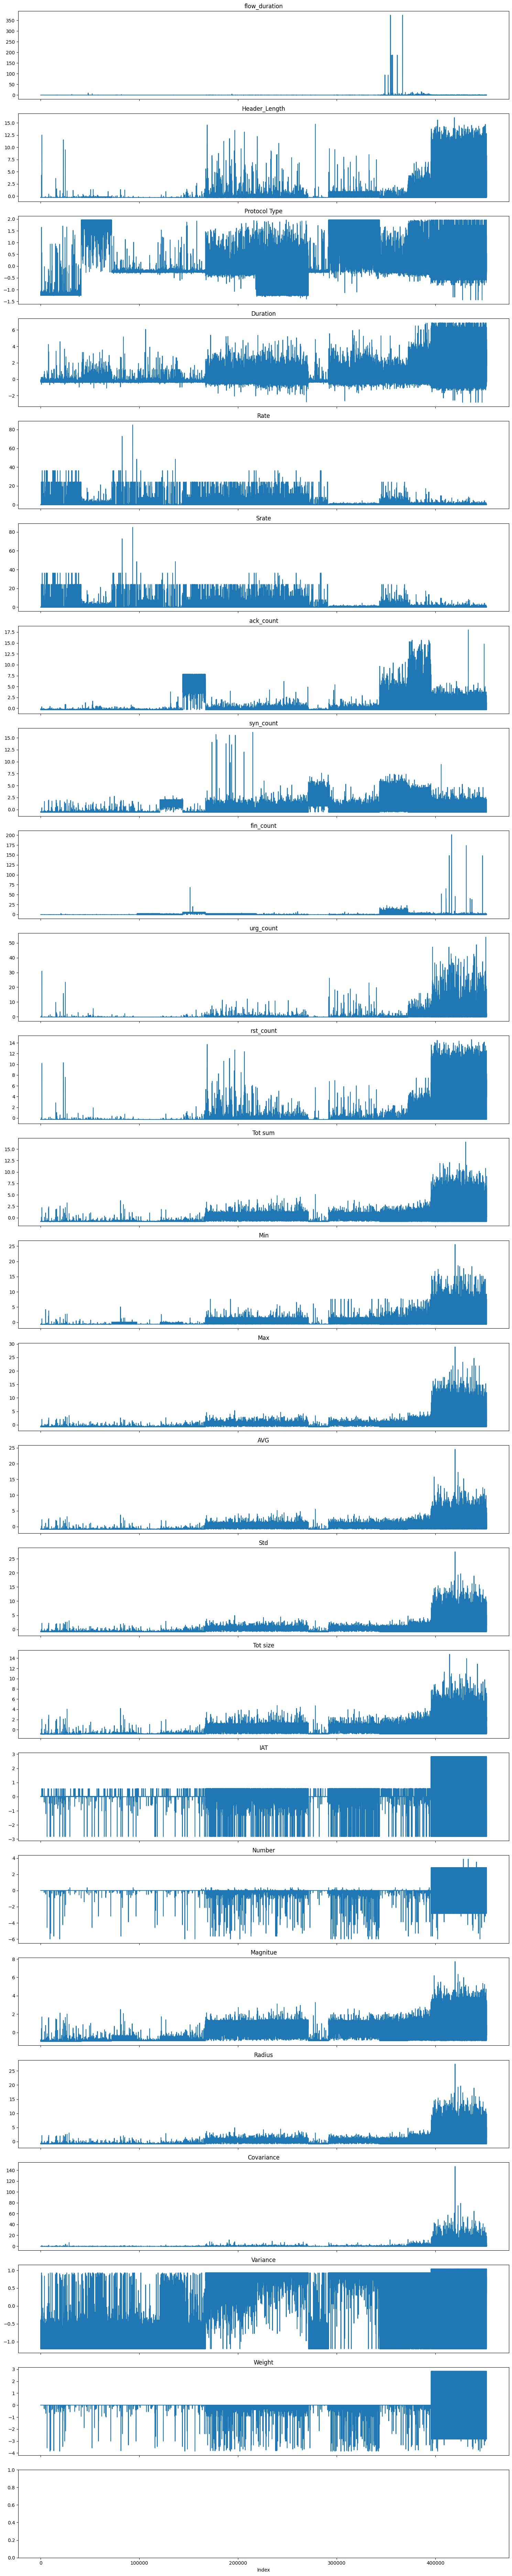

In [ ]:
# View features
# Determine the number of features
import pandas as pd
import matplotlib.pyplot as plt

# Determine the number of features
num_features = len(df.columns)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(15, 3 * num_features), sharex=True)

# Plot each feature in a separate subplot
for i, column in enumerate(df.columns):
    if column != 'label':  # Exclude the label column if present
        axes[i].plot(df.index, df[column])
        axes[i].set_title(column)

plt.xlabel('Index')
plt.tight_layout()
plt.show()
num_features = len(df.columns)


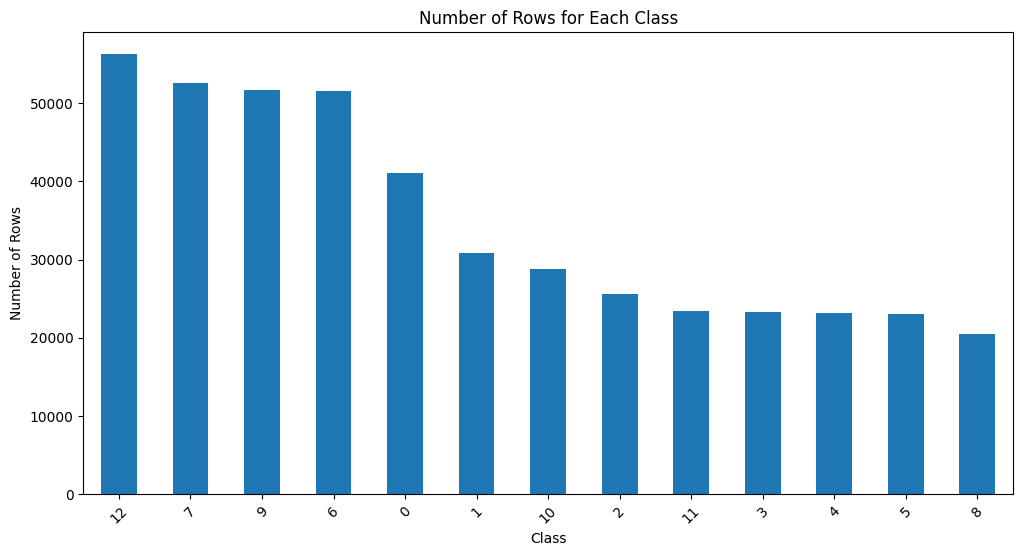

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of rows for each class in the 'Label' column
class_counts = df['label'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar')
plt.title('Number of Rows for Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.show()


## 3.3 Prepare Sliding Window

In [ ]:
import pandas as pd
import torch
from tsai.all import TST, TSDatasets, TSDataLoaders, TSStandardize, get_splits, SlidingWindowPanel
from fastai.learner import Learner
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import accuracy
from fastai.data.transforms import Categorize
from sklearn.model_selection import train_test_split

# Reassign the label column to ensure it is at the correct position
label = df['label']
df.drop('label', axis=1, inplace=True)

#insert the unique_id column
df['unique_id'] = 1

#readd the label column
df['label'] = label.values


# Check if 'unique_id' exists or create a dummy one
if 'unique_id' not in df.columns:
    raise KeyError("The DataFrame does not contain a 'unique_id' column.")

# Ensure the label column is correctly named
if 'label' not in df.columns:
    raise KeyError("The DataFrame does not contain a 'Label' column.")
# Apply SlidingWindowPanel

X, y = SlidingWindowPanel(window_len=10, unique_id_cols=['unique_id'], stride=1, start=0, get_x=df.columns[:-2], get_y=['label'],
                          horizon=0, seq_first=True, sort_by=None, ascending=True, return_key=False)(df)


processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


## 3.4 Setup Model for cic-2023

In [ ]:
# Check the shapes of X and y
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (451904, 46, 10), y shape: (451904,)


stratify set to False as the least populated class in o has only 1 member, which is too few.


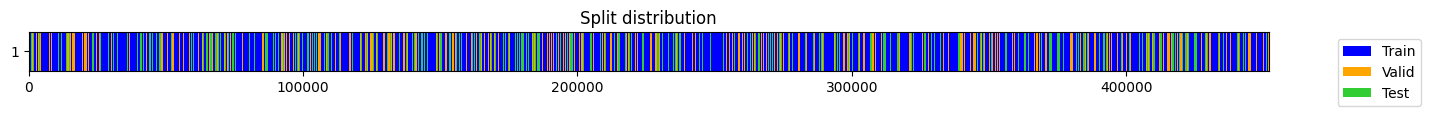

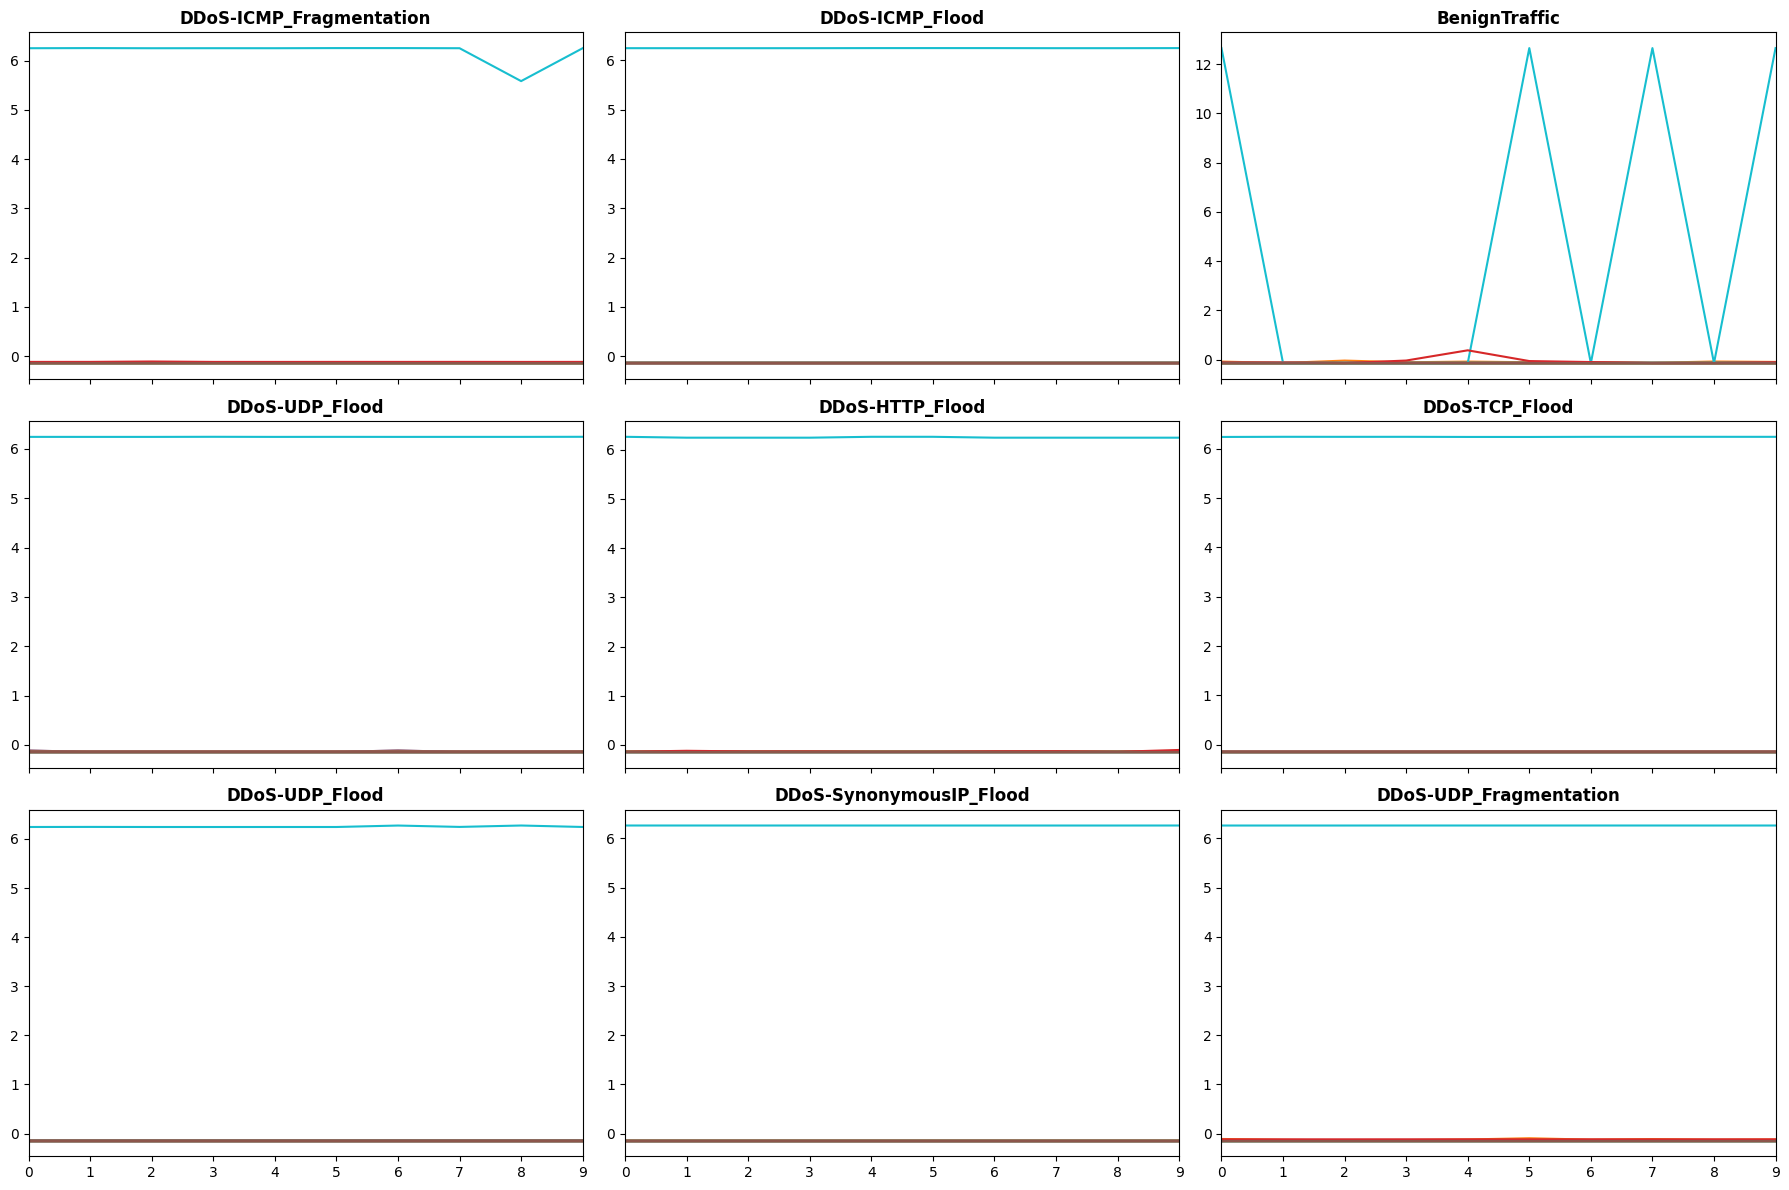

In [ ]:
# Get splits for training and validation sets

n_splits                = 1
valid_size              = 0.2
test_size               = 0.2
train_only              = False  # set to True for debugging (valid = train)
train_size              = None
stratify                = True
balance                 = False
shuffle                 = True
predefined_splits       = None
show_plot               = True
check_splits = True
random_state = 23
# Now use `get_splits` on the remaining data to create training and validation sets
splits = get_splits(X, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)

# Define parameters based on your data shape
bs = 64  # Batch size
c_in = X.shape[1]  # Number of features per timestep (channels in)
c_out = len(set(y))  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)

# Model configuration
d_model = c_in  # Feature dimensionality matches c_in
n_heads = 4  # Number of attention heads
d_k = d_v = d_model // n_heads  # Dimensionality of key/value vectors
d_ff = 256  # Dimensionality of the feedforward network
dropout = 0.1  # Dropout rate
activation = "gelu"  # Activation function
n_layers = 3  # Number of encoder layers
fc_dropout = 0.1  # Dropout rate in the fully connected layer

tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2], batch_tfms=[TSStandardize()], num_workers=0)

dls.show_batch()

# Define the TST model
tst_model = TST(c_in, c_out, seq_len=seq_len, d_model=d_model, n_heads=n_heads,
               d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, act=activation, n_layers=n_layers,
                fc_dropout=fc_dropout)


## 3.5 Build learner cic-2023

flatten


FLOPs: 1016780
| name                | #elements or shape   |
|:--------------------|:---------------------|
| model               | 0.1M                 |
|  W_pos              |  (10, 46)            |
|  W_P                |  2.2K                |
|   W_P.weight        |   (46, 46)           |
|   W_P.bias          |   (46,)              |
|  encoder            |  96.4K               |
|   encoder.layers    |   96.4K              |
|    encoder.layers.0 |    32.1K             |
|    encoder.layers.1 |    32.1K             |
|    encoder.layers.2 |    32.1K             |
|  head               |  6.0K                |
|   head.3            |   6.0K               |
|    head.3.weight    |    (13, 460)         |
|    head.3.bias      |    (13,)             |


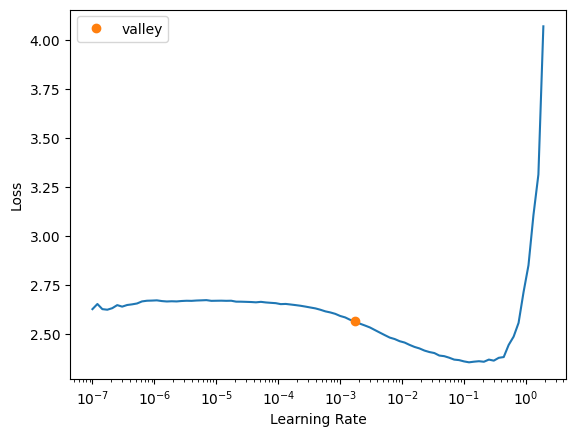

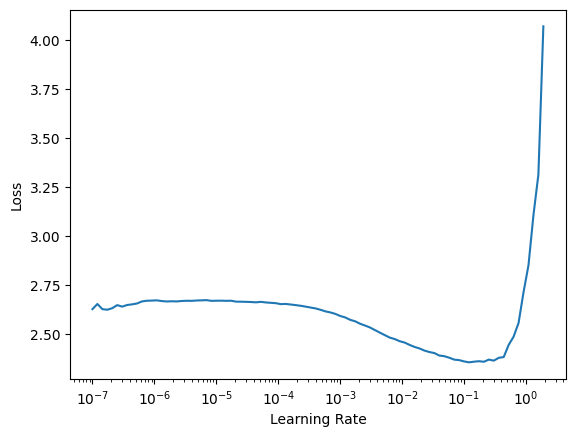

In [ ]:
import torch
from fastai.vision.all import *
from tsai.all import *
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Assuming `dls` is your DataLoader and `tst_model` is your model
# Create the learner with the TST model and the data loaders
learner = Learner(dls, tst_model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy])

# Find an optimal learning rate
learner.lr_find() # Adjust `num_it` based on your dataset size

# Plot the learning rate finder results
learner.recorder.plot_lr_find()

# Calculate and print FLOPs
def print_flops(learner, dls):
    # Generate a dummy input tensor based on the data loader's shape
    dummy_input = next(iter(dls.train))[0][:1]

    # Move the dummy input to the same device as the model
    device = next(learner.model.parameters()).device
    dummy_input = dummy_input.to(device)

    # Calculate FLOPs
    flops = FlopCountAnalysis(learner.model, dummy_input)

    # Print the FLOPs and parameter count
    print(f"FLOPs: {flops.total()}")
    print(parameter_count_table(learner.model))

# Call the print_flops function
print_flops(learner, dls)



### Train Model

In [ ]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=e1401bcf6806d8c1bb0500c49a53039f37b1b9c442326b4de58aff03cb642ab8
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31529 sha256=2dca15d441a872d4920119b10c54cb518aac56600533378ef84f46c12556b3e2
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
# Train the model
learner.fit_one_cycle(1, lr_max=1e-3)

learner.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.478990,0.418414,0.860987,01:22


not enough values to plot a chart


In [ ]:
learner = Learner(dls, tst_model, loss_func=CrossEntropyLossFlat(), metrics=[FBeta(beta=1, average='macro')])
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,fbeta_score,time
0,0.029890,0.025604,0.985522,00:35


### Visualize results

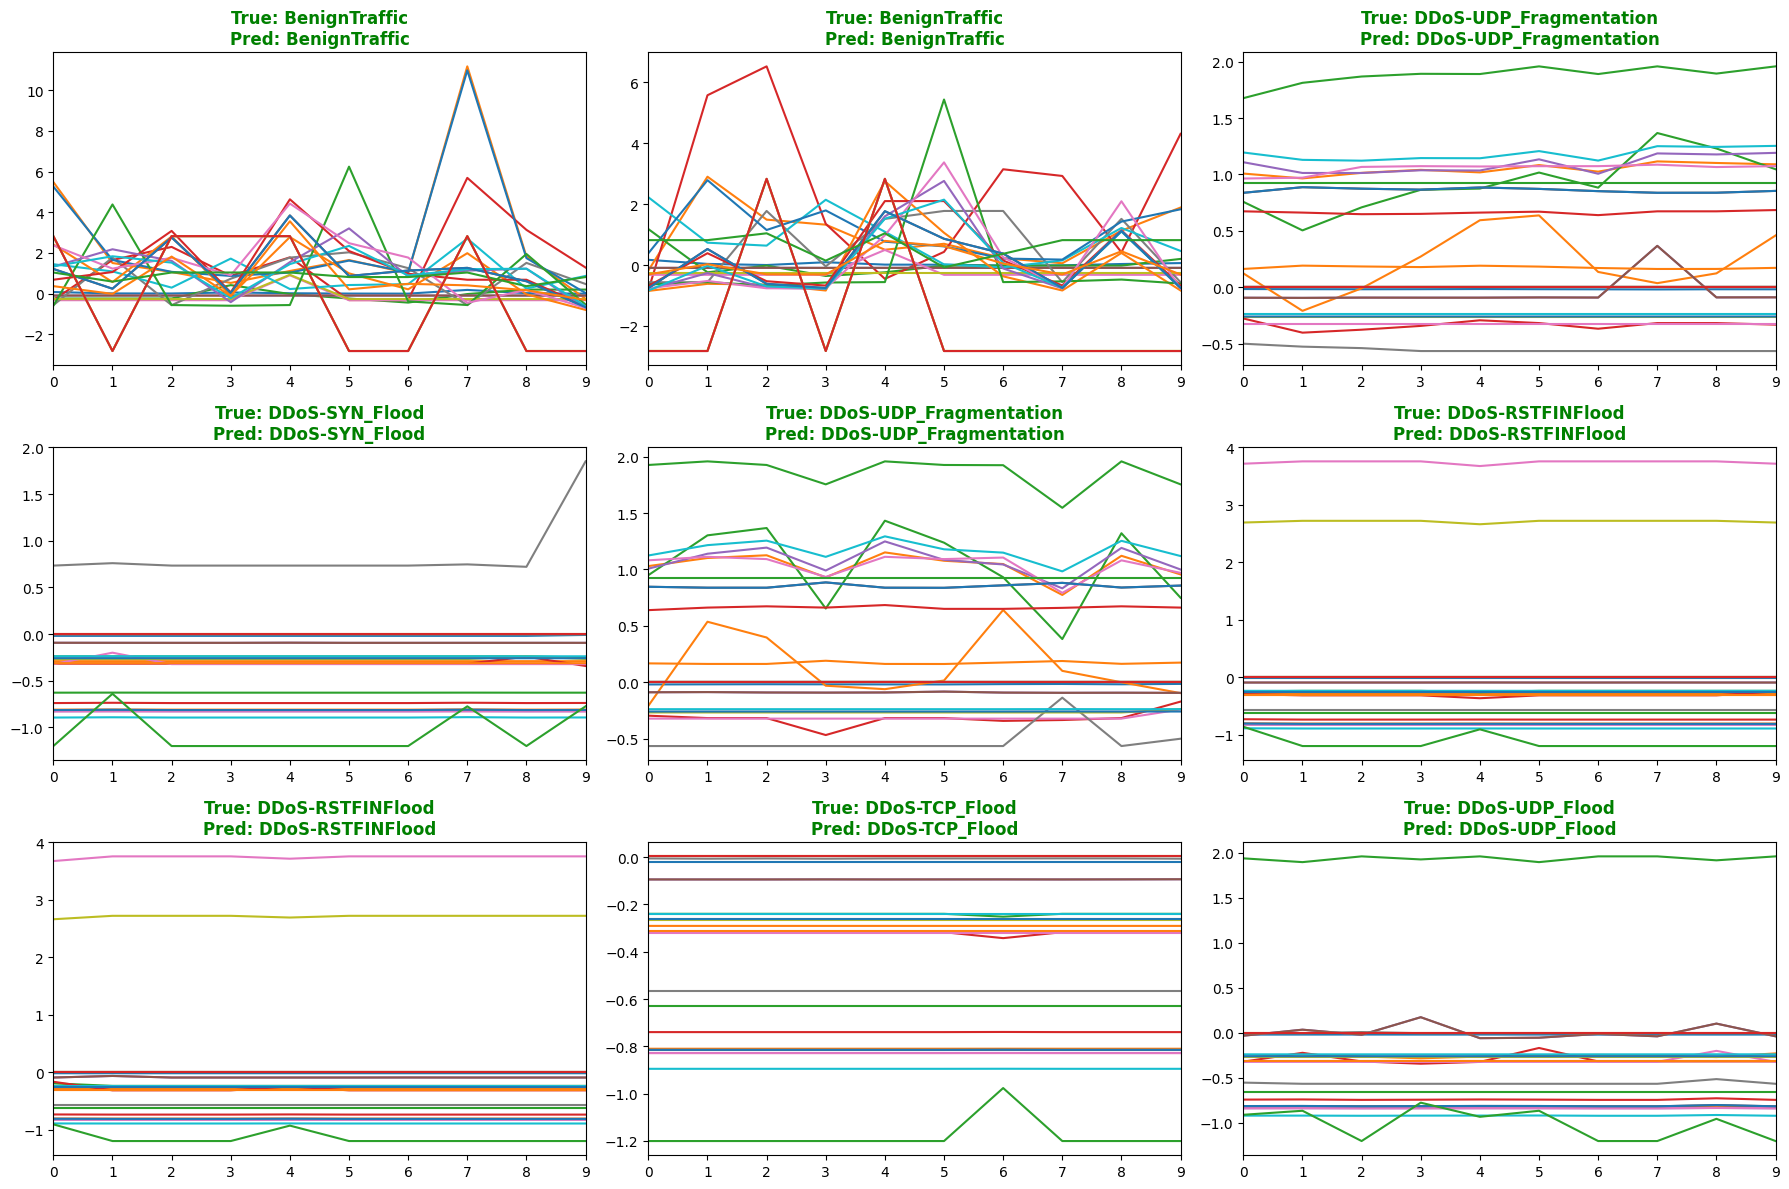

In [ ]:
learner.show_results()

##3.6 view evaluation results and plots



epoch,train_loss,valid_loss,accuracy,time
0,0.054520,0.052893,0.978380,01:20
1,0.039704,0.036955,0.985262,01:22


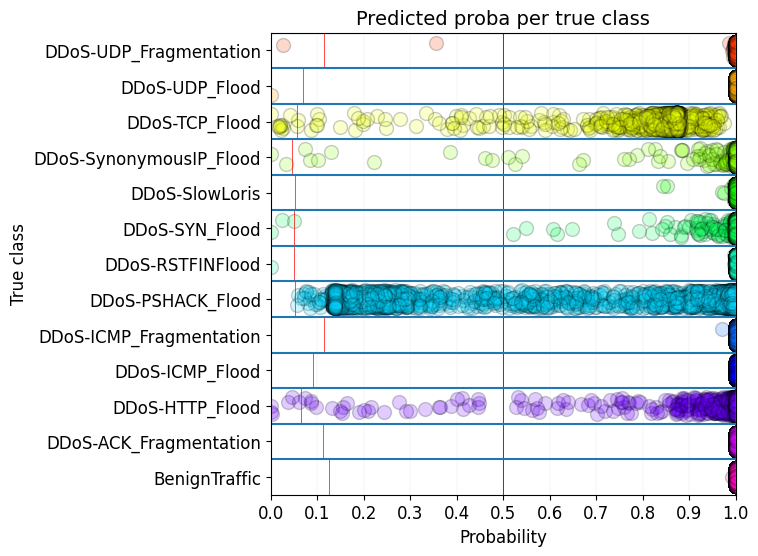

In [ ]:
# Plot predicted probabilities for a subset of the validation or test set
learner.show_probas()

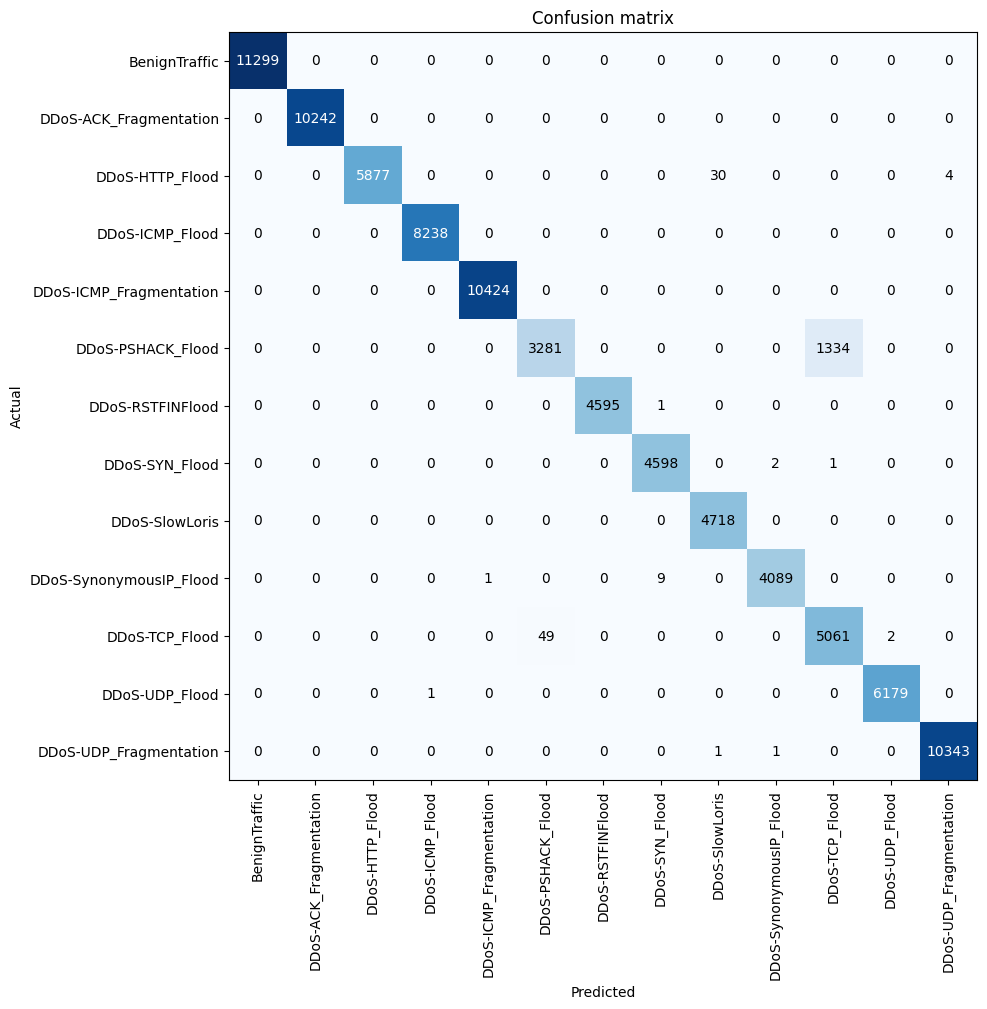

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)  # Specify the DataLoader if evaluating on test data
interp.plot_confusion_matrix(figsize=(10, 10))

##3.7 Evaluate with RNN and view results



In [ ]:
from tsai.metrics import F1_multi
# Make sure tsai and its dependencies are installed
# pip install tsai

from tsai.all import *  # This imports the necessary modules from tsai

# Check and ensure that 'dls' is defined and correctly configured
dls2 = dls

# Parameters
bs = 64  # Batch size
c_in = 24  # Number of features per timestep (channels in)
c_out = 13  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
fc_dropout = 0.5
rnn_dropout = 0.5

# Define the RNN model
# Assuming RNN is correctly imported and available from tsai
model2 = RNN(c_in=c_in, c_out=c_out, hidden_size=100, n_layers=3, bias=True,
             rnn_dropout=rnn_dropout, bidirectional=False, fc_dropout=fc_dropout, init_weights=True)

# Learner initialization
learn = Learner(dls2, model2, metrics=[FBeta(beta=1, average='macro')])

# Model training
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,fbeta_score,time
0,0.078457,0.078429,0.898394,00:37


In [ ]:
model2 = RNN(c_in=c_in, c_out=c_out, hidden_size=100, n_layers=3, bias=True,
             rnn_dropout=rnn_dropout, bidirectional=False, fc_dropout=fc_dropout, init_weights=True)

# Learner initialization
learn = Learner(dls2, model2, metrics=[accuracy])

# Model training
learn.fit_one_cycle(1, 3e-3)

print_flops(learn, dls2)

epoch,train_loss,valid_loss,accuracy,time
0,0.079042,0.080362,0.947809,00:34


FLOPs: 1300
| name               | #elements or shape   |
|:-------------------|:---------------------|
| model              | 54.3K                |
|  rnn               |  53.0K               |
|   rnn.weight_ih_l0 |   (100, 24)          |
|   rnn.weight_hh_l0 |   (100, 100)         |
|   rnn.bias_ih_l0   |   (100,)             |
|   rnn.bias_hh_l0   |   (100,)             |
|   rnn.weight_ih_l1 |   (100, 100)         |
|   rnn.weight_hh_l1 |   (100, 100)         |
|   rnn.bias_ih_l1   |   (100,)             |
|   rnn.bias_hh_l1   |   (100,)             |
|   rnn.weight_ih_l2 |   (100, 100)         |
|   rnn.weight_hh_l2 |   (100, 100)         |
|   rnn.bias_ih_l2   |   (100,)             |
|   rnn.bias_hh_l2   |   (100,)             |
|  fc                |  1.3K                |
|   fc.weight        |   (13, 100)          |
|   fc.bias          |   (13,)              |


### 3.7b Transformer RNN

In [ ]:
# Parameters
bs = 64  # Batch size
c_in = 24  # Number of features per timestep (channels in)
c_out = 13  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
fc_dropout = 0.5
rnn_dropout = 0.5

# Define the RNN model
# Assuming RNN is correctly imported and available from tsai
model4 = TransformerLSTMPlus(c_in=c_in, c_out=c_out, seq_len = seq_len, num_encoder_layers=3, bias=True, bidirectional=False)

# Learner initialization
learn = Learner(dls2, model4, metrics=accuracy)

# Model training
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.054435,0.056650,0.976344,01:23


In [ ]:
model3 = TransformerLSTMPlus(c_in=c_in, c_out=c_out, seq_len = seq_len, num_encoder_layers=3, bias=True, bidirectional=False)

# Learner initialization
learn = Learner(dls2, model3, metrics=[FBeta(beta=1, average='macro')])
learn.fit_one_cycle(1, 3e-3)
print_flops(learn, dls2)

epoch,train_loss,valid_loss,fbeta_score,time
0,0.053235,0.055021,0.965607,01:24


backbone.enc_layers.0.self_attn.out_proj, backbone.enc_layers.1.self_attn.out_proj, backbone.enc_layers.2.self_attn.out_proj


FLOPs: 17765504
| name                           | #elements or shape   |
|:-------------------------------|:---------------------|
| model                          | 1.9M                 |
|  backbone                      |  1.9M                |
|   backbone.pos_encoding        |   (1, 10, 128)       |
|   backbone.proj_linear         |   3.2K               |
|    backbone.proj_linear.weight |    (128, 24)         |
|    backbone.proj_linear.bias   |    (128,)            |
|   backbone.enc_layers          |   1.8M               |
|    backbone.enc_layers.0       |    0.6M              |
|    backbone.enc_layers.1       |    0.6M              |
|    backbone.enc_layers.2       |    0.6M              |
|   backbone.rnn_layers          |   0.1M               |
|    backbone.rnn_layers.0       |    0.1M              |
|  head                          |  1.7K                |
|   head.2                       |   1.7K               |
|    head.2.weight               |    (13, 128)         

### 3.7b LSTM

In [ ]:
# Make sure tsai and its dependencies are installed
# pip install tsai

dls2 = dls

# Parameters
bs = 64  # Batch size
c_in = 24  # Number of features per timestep (channels in)
c_out = 13  # Number of output classes
seq_len = 10  # Sequence length (timesteps per feature)
fc_dropout = 0.5
rnn_dropout = 0.5

# Define the RNN model
# Assuming RNN is correctly imported and available from tsai
model4 = LSTM(c_in=c_in, c_out=c_out, hidden_size=100, n_layers=3, bias=True,
             rnn_dropout=rnn_dropout, bidirectional=False, fc_dropout=fc_dropout, init_weights=True)

# Learner initialization
learn = Learner(dls2, model4, metrics=accuracy)

# Model training
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.080447,0.077649,0.948473,00:36


In [ ]:
# Learner initialization
learn = Learner(dls2, model4, metrics=[FBeta(beta=1, average='macro')])

# Model training
learn.fit_one_cycle(1, 3e-3)
print_flops(learn, dls2)

epoch,train_loss,valid_loss,fbeta_score,time
0,0.036403,0.028297,0.988797,00:36


FLOPs: 1300
| name               | #elements or shape   |
|:-------------------|:---------------------|
| model              | 0.2M                 |
|  rnn               |  0.2M                |
|   rnn.weight_ih_l0 |   (400, 24)          |
|   rnn.weight_hh_l0 |   (400, 100)         |
|   rnn.bias_ih_l0   |   (400,)             |
|   rnn.bias_hh_l0   |   (400,)             |
|   rnn.weight_ih_l1 |   (400, 100)         |
|   rnn.weight_hh_l1 |   (400, 100)         |
|   rnn.bias_ih_l1   |   (400,)             |
|   rnn.bias_hh_l1   |   (400,)             |
|   rnn.weight_ih_l2 |   (400, 100)         |
|   rnn.weight_hh_l2 |   (400, 100)         |
|   rnn.bias_ih_l2   |   (400,)             |
|   rnn.bias_hh_l2   |   (400,)             |
|  fc                |  1.3K                |
|   fc.weight        |   (13, 100)          |
|   fc.bias          |   (13,)              |


## 3.8 Evaluating Logistic Regression and XGBoost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import numpy as np

# Assuming 'df' is your DataFrame where the last column is the target variable

# Load or generate your DataFrame 'df' here

# Separating features and target
X = df.iloc[:, :-1]  # All rows, all columns except the last one as features
y = df.iloc[:, -1]   # All rows, last column as target

# Convert y to numeric if it is not already
y = pd.factorize(y)[0]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression for multiclass
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Metrics
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression F1 Score (Macro):", f1_score(y_test, lr_predictions, average='macro'))

# AUC-ROC (Multiclass requires binarization of the label)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
lr_probs = lr_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_bin, lr_probs, multi_class='ovr', average='macro')
print("Logistic Regression AUC-ROC (Macro):", roc_auc)

print("Logistic Regression Classification Report:\n", classification_report(y_test, lr_predictions))

# XGBoost for multiclass
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Adjust XGBoost parameters for multiclass
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss'
}

# Train XGBoost model
epochs = 10
xgb_model = xgb.train(params, dtrain, epochs)
xgb_predictions = np.argmax(xgb_model.predict(dtest), axis=1)

# Metrics
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost F1 Score (Macro):", f1_score(y_test, xgb_predictions, average='macro'))

# AUC-ROC for XGBoost
xgb_probs = xgb_model.predict(dtest)
roc_auc_xgb = roc_auc_score(y_test_bin, xgb_probs, multi_class='ovr', average='macro')
print("XGBoost AUC-ROC (Macro):", roc_auc_xgb)

print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))


Logistic Regression Accuracy: 0.9364701196394589
Logistic Regression F1 Score (Macro): 0.9207678524841044
Logistic Regression AUC-ROC (Macro): 0.9942245624865953
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12258
           1       1.00      1.00      1.00      9212
           2       0.99      1.00      0.99      7821
           3       0.98      0.99      0.99      6935
           4       0.75      0.95      0.84      6865
           5       1.00      1.00      1.00      6915
           6       0.98      0.98      0.98     15559
           7       0.99      0.98      0.98     15818
           8       0.95      0.69      0.80      6040
           9       0.99      0.98      0.99     15595
          10       0.85      0.92      0.88      8592
          11       0.79      0.55      0.65      7007
          12       0.84      0.91      0.87     16957

    accuracy                        